## **MLP** model created by P.D. from scratch
---

# 1. Install dependencies and packages

In [1]:
import pandas as pd 
import numpy as np 
import torch, torch.nn as nn
import torch.optim as optim 
import tqdm 
from tqdm import tqdm
import functools, sys
from datasets import Dataset

## Helper function

## Set seed

In [2]:
seed = 43
torch.manual_seed(seed)

In [3]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call the `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "mps" if torch.cuda.is_available() else "cpu"
  if device != "mps":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


# 2. Read data

In [6]:
df = pd.read_pickle('results/inflacion.pkl')[['text', 'label']]
df = df[df.label != 'neutro']
df['label'] = df['label'].replace({'negativo':0,'positivo':1})

In [7]:
# 1. FIrst remove punctuation 
import re, string
tqdm.pandas()

def preprocess(text):
  text = text.lower()
  text = text.strip()
  text = re.sub(r'\d','', text)
  text = re.compile('[%s]'% re.escape(string.punctuation)).sub(' ', text)
  return text

df['text'] = df['text'].progress_apply(preprocess)

  0%|          | 0/10207 [00:00<?, ?it/s]

100%|██████████| 10207/10207 [00:00<00:00, 37477.66it/s]


In [8]:
# 2. remove stopwords
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords','punkt')

stop_words = set(stopwords.words('spanish')) | set(stopwords.words('english'))

def stopword(text):
       if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
       elif isinstance(text, pd.Series):
            return text.apply(stopword)  # Apply stopword method to each element in the Series
       else:
           return text
       
df['text'] = df['text'].progress_apply(stopword)

[nltk_data] Downloading package stopwords to punkt...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 10207/10207 [00:00<00:00, 82744.98it/s]


In [9]:
#df = df.drop_duplicates()

# CBOW

In [10]:
#Split words for vocabulary
word_list = []
for sent in df.text:
  for word in sent.split():
    word_list.append(word)

from collections import Counter
corpus = Counter(word_list)
total_word = len(word_list)
sorted_corpus = corpus.most_common(total_word)

In [11]:
#create the dictionary
onehot_dict = {w:i+1 for i, (w,c) in enumerate(sorted_corpus)}

feat = list()
for word in df.text:
  feature = list()
  for words in word.split():
    if words not in list(onehot_dict.keys()):
      feature.append(0)
    else:
      feature.append(onehot_dict[words])
  feat.append(feature)

In [12]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


features = padding_(feat,max(list([len(i) for i in feat])))

In [13]:
features

array([[    0,     0,     0, ...,   447,  1765,     1],
       [    0,     0,     0, ...,  4400, 13083,   294],
       [    0,     0,     0, ...,  4400, 13083,   294],
       ...,
       [    0,     0,     0, ...,    47,  1127,     3],
       [    0,     0,     0, ...,  1174,   276,   273],
       [    0,     0,     0, ...,    47,  1127,     3]])

In [18]:
type(features), type(df.label.values)

(numpy.ndarray, numpy.ndarray)

In [14]:
# Convert to tensors
labels = torch.tensor(df.label.values, dtype=torch.float32)
features = torch.tensor(features, dtype=torch.float32)
labels.shape, features.shape

(torch.Size([10207]), torch.Size([10207, 237]))

In [15]:
from torch.utils.data import Dataset, TensorDataset

#Create Tensor Dataset 
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

In [16]:
features.shape, labels.shape

(torch.Size([10207, 237]), torch.Size([10207]))

In [17]:
#Split dataset

train_split = int(0.8*len(features))

train_x, train_y = features[:train_split], labels[:train_split]

test_x, test_y = features[train_split:], labels[train_split:]

print(len(train_x), len(train_y), len(test_x), len(test_y))

8165 8165 2042 2042


In [18]:
## Step 3-B: wrap the encode and transformation function ... 
def collate_batch(batch):
  label_list, text_list, lengths = [], [], [] 
  for _label, _text in batch:
    label_list.append(label_pipeline(_label)) 
    processed_text = torch.tensor(text_pipeline(_text), 
                                  dtype=torch.int64) 
    text_list.append(processed_text) 
    lengths.append(processed_text.size(0)) 
    label_list = torch.tensor(label_list) 
    lengths = torch.tensor(lengths) 
    padded_text_list = nn.utils.rnn.pad_sequence( 
      text_list, batch_first=True) 
    return padded_text_list, label_list, lengths

In [34]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

#create Tensor Dataset
g_seed = torch.Generator()
g_seed.manual_seed(SEED)


train_data=TensorDataset(torch.FloatTensor(train_x),
                         torch.FloatTensor(train_y))
test_data=TensorDataset(torch.FloatTensor(test_x),
                        torch.FloatTensor(test_y))

#dataloader
batch_size=20
train_loader=DataLoader(train_data,batch_size=batch_size,
                        drop_last=True,shuffle=False, 
                        #collate_fn=collate_batch,
                        num_workers=0,worker_init_fn=seed_worker,
                        generator=g_seed)
test_loader=DataLoader(test_data,batch_size=batch_size,
                       drop_last=True,shuffle=False, 
                       #collate_fn=collate_batch,
                       num_workers=0,worker_init_fn=seed_worker,
                       generator=g_seed)

In [35]:
train_data.tensors[0].shape, train_data.tensors[1].view(-1,1).shape

(torch.Size([8165, 237]), torch.Size([8165, 1]))

In [37]:
train_loader.dataset.__dict__

{'tensors': (tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4700e+02, 1.7650e+03,
           1.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4000e+03, 1.3083e+04,
           2.9400e+02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.4000e+03, 1.3083e+04,
           2.9400e+02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2900e+02, 1.5790e+03,
           1.5020e+03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4650e+03, 1.6600e+02,
           3.6400e+02],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.2900e+02, 1.5790e+03,
           1.5020e+03]]),
  tensor([0., 0., 0.,  ..., 0., 0., 0.]))}

## 2. Convert dataset into ``torch`` dataset

In [113]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
train, test = train_test_split(df, test_size = 0.2)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)
train_data = Dataset.from_pandas(train)
test_data = Dataset.from_pandas(test)
del train, test

## 3. Apply tokenizer with spacy spanish

In [67]:
!python -m spacy download es_core_news_sm --quiet

✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [114]:
import torchtext

tokenizer = torchtext.data.utils.get_tokenizer('spacy', 'es_core_news_sm')

def tokenize_data(example, tokenizer, max_length):
  tokens = tokenizer(example['text'])[:max_length]
  length = len(tokens)
  return {'tokens':tokens, 'length':length}

In [115]:
max_length = 300
train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer':tokenizer, 'max_length':max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer':tokenizer, 'max_length':max_length})

Map:   0%|          | 0/8165 [00:00<?, ? examples/s]

Map:   0%|          | 0/2042 [00:00<?, ? examples/s]

In [116]:
train_data

Dataset({
    features: ['text', 'label', 'tokens', 'length'],
    num_rows: 8165
})

## Split train validation

In [117]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size = test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [118]:
min_freq = 5
special_tokens = ['<unk>','<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                 min_freq = min_freq,
                                                 specials = special_tokens)

unk_index = vocab['<unk>']
pad_index = vocab['<pad>']

vocab.set_default_index(unk_index)

In [119]:
def numericalize_data(example, vocab):
  ids = [vocab[token] for token in example['tokens']]
  return {'ids':ids}

In [120]:
train_data = train_data.map(numericalize_data, fn_kwargs = {'vocab':vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs = {'vocab':vocab})
test_data = test_data.map(numericalize_data, fn_kwargs = {'vocab':vocab})

Map:   0%|          | 0/6123 [00:00<?, ? examples/s]

Map:   0%|          | 0/2042 [00:00<?, ? examples/s]

Map:   0%|          | 0/2042 [00:00<?, ? examples/s]

In [121]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label', 'length'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label', 'length'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label', 'length'])

In [82]:
train_data.__dict__

{'_info': DatasetInfo(description='', citation='', homepage='', license='', features={'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'length': Value(dtype='int64', id=None), 'ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None),
 '_split': None,
 '_indexes': {},
 '_data': InMemoryTable
 text: string
 label: int64
 tokens: list<item: string>
   child 0, item: string
 length: int64
 ids: list<item: int64>
   child 0, item: int64
 ----
 text: [["inflacion mayor anos inegi desempenara cargo enero diciembre mexico eu naciones centroamericanas aseguraron viernes permitiran impunidad caso accidente ocurrid

## Model

In [38]:
## Define a MLP model

class MLP(nn.Module):
  """
  This is a simple MLP for testing this dataset
  """
  def __init__(self, input_features,output_features, hidden_units=255):
    """
    Constructs of the MultiLayerPerceptron

    Args:
      input: input dimension in Integer
        dimensionality of input data (255)
      output: Integer
        number of class (2)
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)

      returns:
      Nothing
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
      nn.Linear(input_features, hidden_units, bias=True),
      nn.ReLU(),
      #nn.Linear(hidden_units, hidden_units),
      #nn.ReLU(),
      nn.Linear(hidden_units, output_features, bias=True),
      nn.LogSoftmax(dim=1),
    )
  def forward(self, x, apply_sigmoid = False):
    y_out = self.linear_layer_stack(x)
    if apply_sigmoid:
      y_out = torch.softmax(y_out)
    return y_out

In [39]:
input = 237
output = 2
hidden_units = 300

model = MLP(input_features=input, output_features = output,
            hidden_units=hidden_units).to(DEVICE)

In [40]:
model

MLP(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=237, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=2, bias=True)
    (3): LogSoftmax(dim=1)
  )
)

In [41]:
import torch.nn.functional as F
# The three parameters below are in your full control
MAX_EPOCHS = 100 # select number of epochs to train
LR = 1e-5  # choose the step size
BATCH_SIZE = 16  # number of examples per minibatch

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr=LR, weight_decay=1e-5)
#optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.5)

In [42]:
[param.shape for param in model.parameters()]

[torch.Size([300, 237]),
 torch.Size([300]),
 torch.Size([2, 300]),
 torch.Size([2])]

In [43]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 1e-05
)

In [44]:
# Define helper function to evaluate models
def eval_model(model, data_loader, num_batches=np.inf, device=DEVICE):
  """
  To evaluate a given model

  Args:
    model: nn.Module derived class
      The model which is to be evaluated
    data_loader: Iterable
      A configured dataloading utility
    num_batches: Integer
      Size of minibatches
    device: String
      Sets the device. CUDA if available, CPU otherwise

  Returns:
    mean of log loss and mean of log accuracy
  """

  loss_log, acc_log = [], []
  model.to(device=DEVICE)

  # We are just evaluating the model, no need to compute gradients
  with torch.no_grad():
    for batch_id, batch in enumerate(train_loader):
      # If we only evaluate a number of batches, stop after we reach that number
      if batch_id > num_batches:
        break
      # Extract minibatch data
      features, labels = batch[0].to(DEVICE), batch[1].long().to(DEVICE)
      # Evaluate model and loss on minibatch
      preds = model(features)
      loss_log.append(loss_fn(preds, labels).item())
      acc_log.append(torch.mean(1. * (preds.argmax(dim=1) == labels)).item())

  return np.mean(loss_log), np.mean(acc_log)

In [45]:
preds.shape, labels.shape

NameError: name 'preds' is not defined

In [315]:
preds = model(features)
loss = loss_fn(preds, labels)
acc = torch.mean(1.0 * (preds.argmax(dim=1) == labels))
print(preds, '\n', labels, '\n',loss.item(), '\n',acc)

tensor([[ 0.0000e+00, -4.5713e+01],
        [ 0.0000e+00, -1.7669e+02],
        [ 0.0000e+00, -1.1486e+02],
        [ 0.0000e+00, -5.9616e+01],
        [ 0.0000e+00, -5.4268e+01],
        [ 0.0000e+00, -2.3964e+01],
        [ 0.0000e+00, -1.2374e+02],
        [ 0.0000e+00, -3.1565e+01],
        [-5.7245e+01,  0.0000e+00],
        [ 0.0000e+00, -2.8995e+02],
        [ 0.0000e+00, -3.3106e+02],
        [ 0.0000e+00, -1.1695e+02],
        [-4.8673e+01,  0.0000e+00],
        [-2.3842e-07, -1.5492e+01],
        [ 0.0000e+00, -2.3477e+02],
        [ 0.0000e+00, -5.5780e+01],
        [ 0.0000e+00, -9.6707e+01],
        [ 0.0000e+00, -1.4497e+02],
        [ 0.0000e+00, -6.8744e+01],
        [ 0.0000e+00, -4.7353e+01]], grad_fn=<LogSoftmaxBackward0>) 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]) 
 1.192092735635697e-08 
 tensor(1.)


In [316]:
list(zip(preds, preds.argmax(dim=1)==labels))

[(tensor([  0.0000, -45.7129], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -176.6887], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -114.8617], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([  0.0000, -59.6160], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([  0.0000, -54.2684], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([  0.0000, -23.9642], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -123.7373], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([  0.0000, -31.5646], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([-57.2451,   0.0000], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -289.9495], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -331.0571], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([   0.0000, -116.9545], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([-48.6727,   0.0000], grad_fn=<UnbindBackward0>), tensor(True)),
 (tensor([-2.3842e-07, -1.

In [241]:
14/20

0.7

In [49]:
set_seed(seed=SEED)

# Print training stats every LOG_FREQ minibatches
LOG_FREQ = 100

# Frequency for evaluating the validation metrics
VAL_FREQ = 100


# Run training
metrics = {'train_loss':[],
           'train_acc':[],
           'val_loss':[],
           'val_acc':[],
           'val_idx':[]}

step_idx = 0
for epoch in tqdm(range(MAX_EPOCHS)):

  running_loss, running_acc = 0., 0.

  for batch_id, batch in enumerate(train_loader):
    step_idx += 1
    # Extract minibatch data and labels
    features, labels = batch[0].to(DEVICE), batch[1].long().to(DEVICE)

    # Just like before, refresh gradient accumulators.
    # Note that this is now a method of the optimizer.
    optimizer.zero_grad()

    # Evaluate model and loss on minibatch
    preds = model(features)
    loss = loss_fn(preds, labels)
    acc = torch.mean(1.0 * (preds.argmax(dim=1) == labels))

    # Compute gradients
    loss.backward()
    # Update parameters
    # Note how all the magic in the update of the parameters is encapsulated by
    # the optimizer class.
    optimizer.step()
    # Log metrics for plotting
    metrics['train_loss'].append(loss.cpu().item())
    metrics['train_acc'].append(acc.cpu().item())
    #print(metrics)

    if batch_id % VAL_FREQ == (VAL_FREQ - 1):

      # Get an estimate of the validation accuracy with 100 batches
      val_loss, val_acc = eval_model(model, test_loader,
                                      num_batches=16,
                                      device=DEVICE)
      print(val_loss)
      metrics['val_idx'].append(step_idx)
      metrics['val_loss'].append(val_loss)
      metrics['val_acc'].append(val_acc)

      print(f"[VALID] Epoch {epoch + 1} - Batch {batch_id + 1} - "
            f"Loss: {val_loss:.3f} - Acc: {100*val_acc:.3f}%")

    # print statistics
    running_loss += loss.cpu().item()
    running_acc += acc.cpu().item()

    # Print every LOG_FREQ minibatches
    if batch_id % LOG_FREQ == (LOG_FREQ-1):
      print(f"[TRAIN] Epoch {epoch + 1} - Batch {batch_id + 1} - "
            f"Loss: {running_loss / LOG_FREQ:.3f} - "
            f"Acc: {100 * running_acc / LOG_FREQ:.3f}%")

    running_loss, running_acc = 0., 0.

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]

13.901017583797083
[VALID] Epoch 1 - Batch 100 - Loss: 13.901 - Acc: 70.588%
[TRAIN] Epoch 1 - Batch 100 - Loss: 0.031 - Acc: 0.900%
12.153432455352124
[VALID] Epoch 1 - Batch 200 - Loss: 12.153 - Acc: 72.353%
[TRAIN] Epoch 1 - Batch 200 - Loss: 0.016 - Acc: 0.950%


  1%|          | 1/100 [00:00<01:21,  1.21it/s]

8.437086875287445
[VALID] Epoch 1 - Batch 300 - Loss: 8.437 - Acc: 75.294%
[TRAIN] Epoch 1 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.6153057722456643
[VALID] Epoch 1 - Batch 400 - Loss: 1.615 - Acc: 92.353%
[TRAIN] Epoch 1 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.7393259281183
[VALID] Epoch 2 - Batch 100 - Loss: 12.739 - Acc: 70.000%
[TRAIN] Epoch 2 - Batch 100 - Loss: 0.042 - Acc: 0.900%
11.903009219774429
[VALID] Epoch 2 - Batch 200 - Loss: 11.903 - Acc: 73.529%
[TRAIN] Epoch 2 - Batch 200 - Loss: 0.015 - Acc: 0.950%


  2%|▏         | 2/100 [00:01<01:07,  1.46it/s]

10.497129182368607
[VALID] Epoch 2 - Batch 300 - Loss: 10.497 - Acc: 73.529%
[TRAIN] Epoch 2 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.6116529399011383
[VALID] Epoch 2 - Batch 400 - Loss: 1.612 - Acc: 89.412%
[TRAIN] Epoch 2 - Batch 400 - Loss: 0.000 - Acc: 1.000%
13.585952286553734
[VALID] Epoch 3 - Batch 100 - Loss: 13.586 - Acc: 68.824%
[TRAIN] Epoch 3 - Batch 100 - Loss: 0.029 - Acc: 0.900%
13.379846350673366
[VALID] Epoch 3 - Batch 200 - Loss: 13.380 - Acc: 72.353%
[TRAIN] Epoch 3 - Batch 200 - Loss: 0.015 - Acc: 0.950%


  3%|▎         | 3/100 [00:01<00:59,  1.64it/s]

8.44494961216354
[VALID] Epoch 3 - Batch 300 - Loss: 8.445 - Acc: 75.294%
[TRAIN] Epoch 3 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.4109140784715049
[VALID] Epoch 3 - Batch 400 - Loss: 1.411 - Acc: 92.941%
[TRAIN] Epoch 3 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.345613549408668
[VALID] Epoch 4 - Batch 100 - Loss: 12.346 - Acc: 71.176%
[TRAIN] Epoch 4 - Batch 100 - Loss: 0.032 - Acc: 0.850%
12.129540725994636
[VALID] Epoch 4 - Batch 200 - Loss: 12.130 - Acc: 70.000%
[TRAIN] Epoch 4 - Batch 200 - Loss: 0.014 - Acc: 0.950%


  4%|▍         | 4/100 [00:02<00:54,  1.78it/s]

6.193671086693511
[VALID] Epoch 4 - Batch 300 - Loss: 6.194 - Acc: 77.059%
[TRAIN] Epoch 4 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.3396779286762117
[VALID] Epoch 4 - Batch 400 - Loss: 1.340 - Acc: 92.353%
[TRAIN] Epoch 4 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.93882442517754
[VALID] Epoch 5 - Batch 100 - Loss: 11.939 - Acc: 70.588%
[TRAIN] Epoch 5 - Batch 100 - Loss: 0.030 - Acc: 0.900%
12.338238170699162
[VALID] Epoch 5 - Batch 200 - Loss: 12.338 - Acc: 71.176%
[TRAIN] Epoch 5 - Batch 200 - Loss: 0.015 - Acc: 0.950%


  5%|▌         | 5/100 [00:02<00:50,  1.87it/s]

6.692578673801002
[VALID] Epoch 5 - Batch 300 - Loss: 6.693 - Acc: 76.471%
[TRAIN] Epoch 5 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.2670573666265672
[VALID] Epoch 5 - Batch 400 - Loss: 1.267 - Acc: 93.529%
[TRAIN] Epoch 5 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.199449146714281
[VALID] Epoch 6 - Batch 100 - Loss: 12.199 - Acc: 70.588%
[TRAIN] Epoch 6 - Batch 100 - Loss: 0.028 - Acc: 0.900%
12.28683711560991
[VALID] Epoch 6 - Batch 200 - Loss: 12.287 - Acc: 71.176%
[TRAIN] Epoch 6 - Batch 200 - Loss: 0.014 - Acc: 0.950%


  6%|▌         | 6/100 [00:03<00:49,  1.91it/s]

7.3539834150347705
[VALID] Epoch 6 - Batch 300 - Loss: 7.354 - Acc: 77.059%
[TRAIN] Epoch 6 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.0807902905721127
[VALID] Epoch 6 - Batch 400 - Loss: 1.081 - Acc: 93.529%
[TRAIN] Epoch 6 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.576106402680178
[VALID] Epoch 7 - Batch 100 - Loss: 12.576 - Acc: 71.176%
[TRAIN] Epoch 7 - Batch 100 - Loss: 0.033 - Acc: 0.850%
11.822478729922508
[VALID] Epoch 7 - Batch 200 - Loss: 11.822 - Acc: 71.765%
[TRAIN] Epoch 7 - Batch 200 - Loss: 0.014 - Acc: 0.950%


  7%|▋         | 7/100 [00:03<00:47,  1.96it/s]

5.777347185388756
[VALID] Epoch 7 - Batch 300 - Loss: 5.777 - Acc: 79.412%
[TRAIN] Epoch 7 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.0848317221812869
[VALID] Epoch 7 - Batch 400 - Loss: 1.085 - Acc: 90.588%
[TRAIN] Epoch 7 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.656703911292682
[VALID] Epoch 8 - Batch 100 - Loss: 12.657 - Acc: 70.588%
[TRAIN] Epoch 8 - Batch 100 - Loss: 0.026 - Acc: 0.850%
14.27781866008188
[VALID] Epoch 8 - Batch 200 - Loss: 14.278 - Acc: 71.176%
[TRAIN] Epoch 8 - Batch 200 - Loss: 0.011 - Acc: 0.950%


  8%|▊         | 8/100 [00:04<00:48,  1.88it/s]

7.385244961424873
[VALID] Epoch 8 - Batch 300 - Loss: 7.385 - Acc: 76.471%
[TRAIN] Epoch 8 - Batch 300 - Loss: 0.000 - Acc: 1.000%
1.0721958386948562
[VALID] Epoch 8 - Batch 400 - Loss: 1.072 - Acc: 93.529%
[TRAIN] Epoch 8 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.350546976962256
[VALID] Epoch 9 - Batch 100 - Loss: 11.351 - Acc: 74.118%
[TRAIN] Epoch 9 - Batch 100 - Loss: 0.025 - Acc: 0.900%
13.859640588832203
[VALID] Epoch 9 - Batch 200 - Loss: 13.860 - Acc: 72.353%
[TRAIN] Epoch 9 - Batch 200 - Loss: 0.015 - Acc: 0.950%


  9%|▉         | 9/100 [00:05<00:49,  1.85it/s]

7.026376352371538
[VALID] Epoch 9 - Batch 300 - Loss: 7.026 - Acc: 76.471%
[TRAIN] Epoch 9 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.9414233343784856
[VALID] Epoch 9 - Batch 400 - Loss: 0.941 - Acc: 93.529%
[TRAIN] Epoch 9 - Batch 400 - Loss: 0.000 - Acc: 1.000%
12.114985758548036
[VALID] Epoch 10 - Batch 100 - Loss: 12.115 - Acc: 71.176%
[TRAIN] Epoch 10 - Batch 100 - Loss: 0.021 - Acc: 0.900%
13.282483280891793
[VALID] Epoch 10 - Batch 200 - Loss: 13.282 - Acc: 71.176%
[TRAIN] Epoch 10 - Batch 200 - Loss: 0.014 - Acc: 0.950%


 10%|█         | 10/100 [00:05<00:48,  1.86it/s]

6.375538053845656
[VALID] Epoch 10 - Batch 300 - Loss: 6.376 - Acc: 78.824%
[TRAIN] Epoch 10 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.7395964219634031
[VALID] Epoch 10 - Batch 400 - Loss: 0.740 - Acc: 93.529%
[TRAIN] Epoch 10 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.850714103453909
[VALID] Epoch 11 - Batch 100 - Loss: 11.851 - Acc: 72.353%
[TRAIN] Epoch 11 - Batch 100 - Loss: 0.023 - Acc: 0.900%
12.205464007508194
[VALID] Epoch 11 - Batch 200 - Loss: 12.205 - Acc: 72.353%
[TRAIN] Epoch 11 - Batch 200 - Loss: 0.016 - Acc: 0.950%


 11%|█         | 11/100 [00:06<00:46,  1.91it/s]

7.086665685793298
[VALID] Epoch 11 - Batch 300 - Loss: 7.087 - Acc: 78.824%
[TRAIN] Epoch 11 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.764994084101545
[VALID] Epoch 11 - Batch 400 - Loss: 0.765 - Acc: 94.118%
[TRAIN] Epoch 11 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.38639147912753
[VALID] Epoch 12 - Batch 100 - Loss: 11.386 - Acc: 72.353%
[TRAIN] Epoch 12 - Batch 100 - Loss: 0.023 - Acc: 0.900%
11.37132409004601
[VALID] Epoch 12 - Batch 200 - Loss: 11.371 - Acc: 72.941%
[TRAIN] Epoch 12 - Batch 200 - Loss: 0.016 - Acc: 0.950%


 12%|█▏        | 12/100 [00:06<00:46,  1.89it/s]

8.676748871715608
[VALID] Epoch 12 - Batch 300 - Loss: 8.677 - Acc: 76.471%
[TRAIN] Epoch 12 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.5535908277160212
[VALID] Epoch 12 - Batch 400 - Loss: 0.554 - Acc: 95.882%
[TRAIN] Epoch 12 - Batch 400 - Loss: 0.000 - Acc: 1.000%
13.473287677896263
[VALID] Epoch 13 - Batch 100 - Loss: 13.473 - Acc: 71.176%
[TRAIN] Epoch 13 - Batch 100 - Loss: 0.023 - Acc: 0.900%
11.620465142970097
[VALID] Epoch 13 - Batch 200 - Loss: 11.620 - Acc: 72.941%
[TRAIN] Epoch 13 - Batch 200 - Loss: 0.015 - Acc: 0.950%


 13%|█▎        | 13/100 [00:07<00:45,  1.92it/s]

8.104003192000308
[VALID] Epoch 13 - Batch 300 - Loss: 8.104 - Acc: 77.059%
[TRAIN] Epoch 13 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.5880667382222569
[VALID] Epoch 13 - Batch 400 - Loss: 0.588 - Acc: 93.529%
[TRAIN] Epoch 13 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.664381364995888
[VALID] Epoch 14 - Batch 100 - Loss: 11.664 - Acc: 71.765%
[TRAIN] Epoch 14 - Batch 100 - Loss: 0.018 - Acc: 0.900%
12.331470379912675
[VALID] Epoch 14 - Batch 200 - Loss: 12.331 - Acc: 71.765%
[TRAIN] Epoch 14 - Batch 200 - Loss: 0.013 - Acc: 0.950%


 14%|█▍        | 14/100 [00:07<00:43,  1.98it/s]

7.465672622355548
[VALID] Epoch 14 - Batch 300 - Loss: 7.466 - Acc: 79.412%
[TRAIN] Epoch 14 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.6618832495960639
[VALID] Epoch 14 - Batch 400 - Loss: 0.662 - Acc: 93.529%
[TRAIN] Epoch 14 - Batch 400 - Loss: 0.002 - Acc: 0.900%
10.090446347830804
[VALID] Epoch 15 - Batch 100 - Loss: 10.090 - Acc: 72.353%
[TRAIN] Epoch 15 - Batch 100 - Loss: 0.015 - Acc: 0.900%
12.19012912538118
[VALID] Epoch 15 - Batch 200 - Loss: 12.190 - Acc: 72.353%
[TRAIN] Epoch 15 - Batch 200 - Loss: 0.013 - Acc: 0.950%


 15%|█▌        | 15/100 [00:08<00:42,  2.01it/s]

6.528761615726741
[VALID] Epoch 15 - Batch 300 - Loss: 6.529 - Acc: 78.824%
[TRAIN] Epoch 15 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.5411814857359306
[VALID] Epoch 15 - Batch 400 - Loss: 0.541 - Acc: 96.471%
[TRAIN] Epoch 15 - Batch 400 - Loss: 0.000 - Acc: 1.000%
11.006777397691488
[VALID] Epoch 16 - Batch 100 - Loss: 11.007 - Acc: 73.529%
[TRAIN] Epoch 16 - Batch 100 - Loss: 0.016 - Acc: 0.900%
10.657701708239445
[VALID] Epoch 16 - Batch 200 - Loss: 10.658 - Acc: 72.941%
[TRAIN] Epoch 16 - Batch 200 - Loss: 0.014 - Acc: 0.950%
5.855289909503854
[VALID] Epoch 16 - Batch 300 - Loss: 5.855 - Acc: 79.412%
[TRAIN] Epoch 16 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 16%|█▌        | 16/100 [00:08<00:46,  1.82it/s]

0.6562056147382089
[VALID] Epoch 16 - Batch 400 - Loss: 0.656 - Acc: 95.882%
[TRAIN] Epoch 16 - Batch 400 - Loss: 0.000 - Acc: 1.000%
9.829963286966079
[VALID] Epoch 17 - Batch 100 - Loss: 9.830 - Acc: 72.941%
[TRAIN] Epoch 17 - Batch 100 - Loss: 0.015 - Acc: 0.900%
10.192435674174845
[VALID] Epoch 17 - Batch 200 - Loss: 10.192 - Acc: 73.529%
[TRAIN] Epoch 17 - Batch 200 - Loss: 0.016 - Acc: 0.950%
5.030282739507718
[VALID] Epoch 17 - Batch 300 - Loss: 5.030 - Acc: 82.353%
[TRAIN] Epoch 17 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 17%|█▋        | 17/100 [00:09<00:45,  1.83it/s]

0.42752714054470514
[VALID] Epoch 17 - Batch 400 - Loss: 0.428 - Acc: 95.294%
[TRAIN] Epoch 17 - Batch 400 - Loss: 0.000 - Acc: 1.000%
9.79743570431114
[VALID] Epoch 18 - Batch 100 - Loss: 9.797 - Acc: 73.529%
[TRAIN] Epoch 18 - Batch 100 - Loss: 0.014 - Acc: 0.900%
9.960778338504841
[VALID] Epoch 18 - Batch 200 - Loss: 9.961 - Acc: 73.529%
[TRAIN] Epoch 18 - Batch 200 - Loss: 0.018 - Acc: 0.850%
4.250591517368616
[VALID] Epoch 18 - Batch 300 - Loss: 4.251 - Acc: 82.353%
[TRAIN] Epoch 18 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 18%|█▊        | 18/100 [00:09<00:44,  1.83it/s]

0.695551330312703
[VALID] Epoch 18 - Batch 400 - Loss: 0.696 - Acc: 91.765%
[TRAIN] Epoch 18 - Batch 400 - Loss: 0.000 - Acc: 1.000%
9.649644347718421
[VALID] Epoch 19 - Batch 100 - Loss: 9.650 - Acc: 73.529%
[TRAIN] Epoch 19 - Batch 100 - Loss: 0.009 - Acc: 0.900%
11.5992150006706
[VALID] Epoch 19 - Batch 200 - Loss: 11.599 - Acc: 72.353%
[TRAIN] Epoch 19 - Batch 200 - Loss: 0.012 - Acc: 0.950%
4.309110522594368
[VALID] Epoch 19 - Batch 300 - Loss: 4.309 - Acc: 81.176%
[TRAIN] Epoch 19 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 19%|█▉        | 19/100 [00:10<00:43,  1.88it/s]

0.6208666738507685
[VALID] Epoch 19 - Batch 400 - Loss: 0.621 - Acc: 93.529%
[TRAIN] Epoch 19 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.70255849332931
[VALID] Epoch 20 - Batch 100 - Loss: 8.703 - Acc: 74.118%
[TRAIN] Epoch 20 - Batch 100 - Loss: 0.007 - Acc: 0.900%
12.249252002160338
[VALID] Epoch 20 - Batch 200 - Loss: 12.249 - Acc: 71.765%
[TRAIN] Epoch 20 - Batch 200 - Loss: 0.014 - Acc: 0.900%
4.7530355379216385
[VALID] Epoch 20 - Batch 300 - Loss: 4.753 - Acc: 80.588%
[TRAIN] Epoch 20 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 20%|██        | 20/100 [00:10<00:41,  1.94it/s]

0.4695422783204877
[VALID] Epoch 20 - Batch 400 - Loss: 0.470 - Acc: 95.882%
[TRAIN] Epoch 20 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.451954589915625
[VALID] Epoch 21 - Batch 100 - Loss: 8.452 - Acc: 74.706%
[TRAIN] Epoch 21 - Batch 100 - Loss: 0.002 - Acc: 0.900%
11.57299784272908
[VALID] Epoch 21 - Batch 200 - Loss: 11.573 - Acc: 72.941%
[TRAIN] Epoch 21 - Batch 200 - Loss: 0.012 - Acc: 0.950%
4.739308299087561
[VALID] Epoch 21 - Batch 300 - Loss: 4.739 - Acc: 80.588%
[TRAIN] Epoch 21 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 21%|██        | 21/100 [00:11<00:40,  1.94it/s]

0.4783040499868494
[VALID] Epoch 21 - Batch 400 - Loss: 0.478 - Acc: 93.529%
[TRAIN] Epoch 21 - Batch 400 - Loss: 0.000 - Acc: 1.000%
10.004835471904524
[VALID] Epoch 22 - Batch 100 - Loss: 10.005 - Acc: 73.529%
[TRAIN] Epoch 22 - Batch 100 - Loss: 0.001 - Acc: 0.950%
13.14376704114325
[VALID] Epoch 22 - Batch 200 - Loss: 13.144 - Acc: 72.353%
[TRAIN] Epoch 22 - Batch 200 - Loss: 0.013 - Acc: 0.950%
4.735455333926454
[VALID] Epoch 22 - Batch 300 - Loss: 4.735 - Acc: 80.588%
[TRAIN] Epoch 22 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 22%|██▏       | 22/100 [00:11<00:39,  1.98it/s]

0.5654345856823698
[VALID] Epoch 22 - Batch 400 - Loss: 0.565 - Acc: 92.941%
[TRAIN] Epoch 22 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.411617929575932
[VALID] Epoch 23 - Batch 100 - Loss: 8.412 - Acc: 74.118%
[TRAIN] Epoch 23 - Batch 100 - Loss: 0.001 - Acc: 0.900%
10.396955690532804
[VALID] Epoch 23 - Batch 200 - Loss: 10.397 - Acc: 72.941%
[TRAIN] Epoch 23 - Batch 200 - Loss: 0.013 - Acc: 0.950%
6.868379613456401
[VALID] Epoch 23 - Batch 300 - Loss: 6.868 - Acc: 77.647%
[TRAIN] Epoch 23 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 23%|██▎       | 23/100 [00:12<00:38,  2.02it/s]

0.5437021886610798
[VALID] Epoch 23 - Batch 400 - Loss: 0.544 - Acc: 94.118%
[TRAIN] Epoch 23 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.85232334634398
[VALID] Epoch 24 - Batch 100 - Loss: 8.852 - Acc: 73.529%
[TRAIN] Epoch 24 - Batch 100 - Loss: 0.001 - Acc: 1.000%
11.399387785397906
[VALID] Epoch 24 - Batch 200 - Loss: 11.399 - Acc: 72.353%
[TRAIN] Epoch 24 - Batch 200 - Loss: 0.012 - Acc: 0.950%
3.814051024402044
[VALID] Epoch 24 - Batch 300 - Loss: 3.814 - Acc: 81.176%
[TRAIN] Epoch 24 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 24%|██▍       | 24/100 [00:12<00:36,  2.06it/s]

0.5190035165848231
[VALID] Epoch 24 - Batch 400 - Loss: 0.519 - Acc: 94.118%
[TRAIN] Epoch 24 - Batch 400 - Loss: 0.000 - Acc: 1.000%
9.946652855198172
[VALID] Epoch 25 - Batch 100 - Loss: 9.947 - Acc: 73.529%
[TRAIN] Epoch 25 - Batch 100 - Loss: 0.000 - Acc: 1.000%
11.54617326014179
[VALID] Epoch 25 - Batch 200 - Loss: 11.546 - Acc: 70.588%
[TRAIN] Epoch 25 - Batch 200 - Loss: 0.012 - Acc: 0.950%
3.085708618049913
[VALID] Epoch 25 - Batch 300 - Loss: 3.086 - Acc: 82.353%
[TRAIN] Epoch 25 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 25%|██▌       | 25/100 [00:13<00:36,  2.03it/s]

0.4102208776530331
[VALID] Epoch 25 - Batch 400 - Loss: 0.410 - Acc: 95.294%
[TRAIN] Epoch 25 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.880828855142873
[VALID] Epoch 26 - Batch 100 - Loss: 8.881 - Acc: 74.118%
[TRAIN] Epoch 26 - Batch 100 - Loss: 0.001 - Acc: 0.950%
8.416867322954712
[VALID] Epoch 26 - Batch 200 - Loss: 8.417 - Acc: 75.294%
[TRAIN] Epoch 26 - Batch 200 - Loss: 0.015 - Acc: 0.950%
4.783750983911113
[VALID] Epoch 26 - Batch 300 - Loss: 4.784 - Acc: 79.412%
[TRAIN] Epoch 26 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 26%|██▌       | 26/100 [00:13<00:36,  2.03it/s]

0.27557606092832476
[VALID] Epoch 26 - Batch 400 - Loss: 0.276 - Acc: 97.059%
[TRAIN] Epoch 26 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.089282402133208
[VALID] Epoch 27 - Batch 100 - Loss: 7.089 - Acc: 74.118%
[TRAIN] Epoch 27 - Batch 100 - Loss: 0.000 - Acc: 1.000%
8.640705956825432
[VALID] Epoch 27 - Batch 200 - Loss: 8.641 - Acc: 72.941%
[TRAIN] Epoch 27 - Batch 200 - Loss: 0.012 - Acc: 0.950%
3.3985277941816414
[VALID] Epoch 27 - Batch 300 - Loss: 3.399 - Acc: 79.412%
[TRAIN] Epoch 27 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 27%|██▋       | 27/100 [00:14<00:36,  1.99it/s]

0.27867931726006434
[VALID] Epoch 27 - Batch 400 - Loss: 0.279 - Acc: 96.471%
[TRAIN] Epoch 27 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.971108327367724
[VALID] Epoch 28 - Batch 100 - Loss: 7.971 - Acc: 74.118%
[TRAIN] Epoch 28 - Batch 100 - Loss: 0.000 - Acc: 1.000%
7.863565988046583
[VALID] Epoch 28 - Batch 200 - Loss: 7.864 - Acc: 75.294%
[TRAIN] Epoch 28 - Batch 200 - Loss: 0.013 - Acc: 0.950%
4.028155988936819
[VALID] Epoch 28 - Batch 300 - Loss: 4.028 - Acc: 79.412%
[TRAIN] Epoch 28 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 28%|██▊       | 28/100 [00:14<00:36,  1.98it/s]

0.48212519899431117
[VALID] Epoch 28 - Batch 400 - Loss: 0.482 - Acc: 93.529%
[TRAIN] Epoch 28 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.425372529051758
[VALID] Epoch 29 - Batch 100 - Loss: 7.425 - Acc: 73.529%
[TRAIN] Epoch 29 - Batch 100 - Loss: 0.000 - Acc: 1.000%
7.770962156442719
[VALID] Epoch 29 - Batch 200 - Loss: 7.771 - Acc: 74.118%
[TRAIN] Epoch 29 - Batch 200 - Loss: 0.011 - Acc: 0.950%
3.3968955006402695
[VALID] Epoch 29 - Batch 300 - Loss: 3.397 - Acc: 81.176%
[TRAIN] Epoch 29 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 29%|██▉       | 29/100 [00:15<00:35,  2.00it/s]

0.4064631448805277
[VALID] Epoch 29 - Batch 400 - Loss: 0.406 - Acc: 94.706%
[TRAIN] Epoch 29 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.771159211677616
[VALID] Epoch 30 - Batch 100 - Loss: 7.771 - Acc: 73.529%
[TRAIN] Epoch 30 - Batch 100 - Loss: 0.000 - Acc: 1.000%
9.49879790715435
[VALID] Epoch 30 - Batch 200 - Loss: 9.499 - Acc: 73.529%
[TRAIN] Epoch 30 - Batch 200 - Loss: 0.010 - Acc: 0.950%
3.612953176692586
[VALID] Epoch 30 - Batch 300 - Loss: 3.613 - Acc: 80.000%
[TRAIN] Epoch 30 - Batch 300 - Loss: 0.000 - Acc: 1.000%


 30%|███       | 30/100 [00:16<00:51,  1.35it/s]

0.312740241826733
[VALID] Epoch 30 - Batch 400 - Loss: 0.313 - Acc: 96.471%
[TRAIN] Epoch 30 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.235476737973422
[VALID] Epoch 31 - Batch 100 - Loss: 7.235 - Acc: 74.118%
[TRAIN] Epoch 31 - Batch 100 - Loss: 0.001 - Acc: 0.900%
5.2677773803906325
[VALID] Epoch 31 - Batch 200 - Loss: 5.268 - Acc: 78.824%
[TRAIN] Epoch 31 - Batch 200 - Loss: 0.011 - Acc: 0.900%


 31%|███       | 31/100 [00:17<00:49,  1.38it/s]

4.019212270957509
[VALID] Epoch 31 - Batch 300 - Loss: 4.019 - Acc: 78.824%
[TRAIN] Epoch 31 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.35153946450468787
[VALID] Epoch 31 - Batch 400 - Loss: 0.352 - Acc: 96.471%
[TRAIN] Epoch 31 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.332636666385552
[VALID] Epoch 32 - Batch 100 - Loss: 7.333 - Acc: 72.941%
[TRAIN] Epoch 32 - Batch 100 - Loss: 0.000 - Acc: 1.000%
6.585520467073613
[VALID] Epoch 32 - Batch 200 - Loss: 6.586 - Acc: 76.471%
[TRAIN] Epoch 32 - Batch 200 - Loss: 0.013 - Acc: 0.950%


 32%|███▏      | 32/100 [00:17<00:45,  1.49it/s]

3.481270508868714
[VALID] Epoch 32 - Batch 300 - Loss: 3.481 - Acc: 81.765%
[TRAIN] Epoch 32 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.25127955513359185
[VALID] Epoch 32 - Batch 400 - Loss: 0.251 - Acc: 96.471%
[TRAIN] Epoch 32 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.995905459124365
[VALID] Epoch 33 - Batch 100 - Loss: 7.996 - Acc: 74.706%
[TRAIN] Epoch 33 - Batch 100 - Loss: 0.000 - Acc: 1.000%
6.613074700621489
[VALID] Epoch 33 - Batch 200 - Loss: 6.613 - Acc: 75.882%
[TRAIN] Epoch 33 - Batch 200 - Loss: 0.013 - Acc: 0.950%


 33%|███▎      | 33/100 [00:18<00:41,  1.61it/s]

4.331331826514917
[VALID] Epoch 33 - Batch 300 - Loss: 4.331 - Acc: 80.000%
[TRAIN] Epoch 33 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.3121401588768233
[VALID] Epoch 33 - Batch 400 - Loss: 0.312 - Acc: 95.882%
[TRAIN] Epoch 33 - Batch 400 - Loss: 0.000 - Acc: 1.000%
6.585154868640401
[VALID] Epoch 34 - Batch 100 - Loss: 6.585 - Acc: 74.706%
[TRAIN] Epoch 34 - Batch 100 - Loss: 0.000 - Acc: 1.000%
5.981787116912515
[VALID] Epoch 34 - Batch 200 - Loss: 5.982 - Acc: 77.059%
[TRAIN] Epoch 34 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 34%|███▍      | 34/100 [00:18<00:38,  1.69it/s]

2.899304212733595
[VALID] Epoch 34 - Batch 300 - Loss: 2.899 - Acc: 82.353%
[TRAIN] Epoch 34 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2460739550455842
[VALID] Epoch 34 - Batch 400 - Loss: 0.246 - Acc: 97.059%
[TRAIN] Epoch 34 - Batch 400 - Loss: 0.000 - Acc: 1.000%
6.580438575059361
[VALID] Epoch 35 - Batch 100 - Loss: 6.580 - Acc: 73.529%
[TRAIN] Epoch 35 - Batch 100 - Loss: 0.000 - Acc: 1.000%
6.739014031255291
[VALID] Epoch 35 - Batch 200 - Loss: 6.739 - Acc: 76.471%
[TRAIN] Epoch 35 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 35%|███▌      | 35/100 [00:19<00:37,  1.75it/s]

5.042352900389126
[VALID] Epoch 35 - Batch 300 - Loss: 5.042 - Acc: 78.824%
[TRAIN] Epoch 35 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.24206292250366512
[VALID] Epoch 35 - Batch 400 - Loss: 0.242 - Acc: 97.647%
[TRAIN] Epoch 35 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.786880840886872
[VALID] Epoch 36 - Batch 100 - Loss: 7.787 - Acc: 74.706%
[TRAIN] Epoch 36 - Batch 100 - Loss: 0.004 - Acc: 0.900%
4.71606706431671
[VALID] Epoch 36 - Batch 200 - Loss: 4.716 - Acc: 78.235%
[TRAIN] Epoch 36 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 36%|███▌      | 36/100 [00:19<00:35,  1.83it/s]

4.432837420514261
[VALID] Epoch 36 - Batch 300 - Loss: 4.433 - Acc: 79.412%
[TRAIN] Epoch 36 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.26063730142639857
[VALID] Epoch 36 - Batch 400 - Loss: 0.261 - Acc: 97.059%
[TRAIN] Epoch 36 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.803068224143313
[VALID] Epoch 37 - Batch 100 - Loss: 7.803 - Acc: 73.529%
[TRAIN] Epoch 37 - Batch 100 - Loss: 0.000 - Acc: 1.000%
5.485352873756068
[VALID] Epoch 37 - Batch 200 - Loss: 5.485 - Acc: 77.059%
[TRAIN] Epoch 37 - Batch 200 - Loss: 0.009 - Acc: 0.950%


 37%|███▋      | 37/100 [00:20<00:34,  1.81it/s]

4.286112791940491
[VALID] Epoch 37 - Batch 300 - Loss: 4.286 - Acc: 80.588%
[TRAIN] Epoch 37 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.270575966612688
[VALID] Epoch 37 - Batch 400 - Loss: 0.271 - Acc: 97.647%
[TRAIN] Epoch 37 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.824774139878493
[VALID] Epoch 38 - Batch 100 - Loss: 5.825 - Acc: 77.059%
[TRAIN] Epoch 38 - Batch 100 - Loss: 0.000 - Acc: 1.000%
6.166072929807931
[VALID] Epoch 38 - Batch 200 - Loss: 6.166 - Acc: 77.059%
[TRAIN] Epoch 38 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 38%|███▊      | 38/100 [00:20<00:35,  1.75it/s]

4.5730740318583285
[VALID] Epoch 38 - Batch 300 - Loss: 4.573 - Acc: 81.765%
[TRAIN] Epoch 38 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.4209738528453399
[VALID] Epoch 38 - Batch 400 - Loss: 0.421 - Acc: 93.529%
[TRAIN] Epoch 38 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.240337073846534
[VALID] Epoch 39 - Batch 100 - Loss: 7.240 - Acc: 74.706%
[TRAIN] Epoch 39 - Batch 100 - Loss: 0.000 - Acc: 1.000%
5.537435585572145
[VALID] Epoch 39 - Batch 200 - Loss: 5.537 - Acc: 77.647%
[TRAIN] Epoch 39 - Batch 200 - Loss: 0.015 - Acc: 0.850%


 39%|███▉      | 39/100 [00:21<00:34,  1.78it/s]

4.526153008155448
[VALID] Epoch 39 - Batch 300 - Loss: 4.526 - Acc: 80.000%
[TRAIN] Epoch 39 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.20050108348685108
[VALID] Epoch 39 - Batch 400 - Loss: 0.201 - Acc: 97.647%
[TRAIN] Epoch 39 - Batch 400 - Loss: 0.013 - Acc: 0.900%
7.737386705550722
[VALID] Epoch 40 - Batch 100 - Loss: 7.737 - Acc: 74.706%
[TRAIN] Epoch 40 - Batch 100 - Loss: 0.000 - Acc: 1.000%
5.793338176252799
[VALID] Epoch 40 - Batch 200 - Loss: 5.793 - Acc: 78.235%
[TRAIN] Epoch 40 - Batch 200 - Loss: 0.012 - Acc: 0.950%


 40%|████      | 40/100 [00:22<00:33,  1.80it/s]

4.415080961436401
[VALID] Epoch 40 - Batch 300 - Loss: 4.415 - Acc: 80.000%
[TRAIN] Epoch 40 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2856066585367066
[VALID] Epoch 40 - Batch 400 - Loss: 0.286 - Acc: 95.882%
[TRAIN] Epoch 40 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.293133119252309
[VALID] Epoch 41 - Batch 100 - Loss: 7.293 - Acc: 75.294%
[TRAIN] Epoch 41 - Batch 100 - Loss: 0.000 - Acc: 1.000%
3.378182441155385
[VALID] Epoch 41 - Batch 200 - Loss: 3.378 - Acc: 81.765%
[TRAIN] Epoch 41 - Batch 200 - Loss: 0.012 - Acc: 0.900%


 41%|████      | 41/100 [00:22<00:31,  1.88it/s]

3.9682121096491434
[VALID] Epoch 41 - Batch 300 - Loss: 3.968 - Acc: 82.353%
[TRAIN] Epoch 41 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.3865280185892409
[VALID] Epoch 41 - Batch 400 - Loss: 0.387 - Acc: 94.706%
[TRAIN] Epoch 41 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.131221622162497
[VALID] Epoch 42 - Batch 100 - Loss: 7.131 - Acc: 76.471%
[TRAIN] Epoch 42 - Batch 100 - Loss: 0.000 - Acc: 1.000%
5.9774319781887675
[VALID] Epoch 42 - Batch 200 - Loss: 5.977 - Acc: 78.235%
[TRAIN] Epoch 42 - Batch 200 - Loss: 0.009 - Acc: 0.950%


 42%|████▏     | 42/100 [00:23<00:29,  1.94it/s]

3.3266015061420844
[VALID] Epoch 42 - Batch 300 - Loss: 3.327 - Acc: 84.706%
[TRAIN] Epoch 42 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2309877192045589
[VALID] Epoch 42 - Batch 400 - Loss: 0.231 - Acc: 97.647%
[TRAIN] Epoch 42 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.786168557076524
[VALID] Epoch 43 - Batch 100 - Loss: 5.786 - Acc: 77.647%
[TRAIN] Epoch 43 - Batch 100 - Loss: 0.000 - Acc: 1.000%
3.6591336905055014
[VALID] Epoch 43 - Batch 200 - Loss: 3.659 - Acc: 82.353%
[TRAIN] Epoch 43 - Batch 200 - Loss: 0.011 - Acc: 0.900%


 43%|████▎     | 43/100 [00:23<00:28,  1.99it/s]

4.5425176580219535
[VALID] Epoch 43 - Batch 300 - Loss: 4.543 - Acc: 82.941%
[TRAIN] Epoch 43 - Batch 300 - Loss: 0.001 - Acc: 0.900%
0.2566019351500151
[VALID] Epoch 43 - Batch 400 - Loss: 0.257 - Acc: 95.882%
[TRAIN] Epoch 43 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.401398235778584
[VALID] Epoch 44 - Batch 100 - Loss: 5.401 - Acc: 79.412%
[TRAIN] Epoch 44 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.9364909877545762
[VALID] Epoch 44 - Batch 200 - Loss: 1.936 - Acc: 88.235%
[TRAIN] Epoch 44 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 44%|████▍     | 44/100 [00:23<00:27,  2.05it/s]

4.985966425504504
[VALID] Epoch 44 - Batch 300 - Loss: 4.986 - Acc: 79.412%
[TRAIN] Epoch 44 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2944973836925891
[VALID] Epoch 44 - Batch 400 - Loss: 0.294 - Acc: 95.294%
[TRAIN] Epoch 44 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.770106679069566
[VALID] Epoch 45 - Batch 100 - Loss: 4.770 - Acc: 80.000%
[TRAIN] Epoch 45 - Batch 100 - Loss: 0.000 - Acc: 1.000%
2.167154614440198
[VALID] Epoch 45 - Batch 200 - Loss: 2.167 - Acc: 87.647%
[TRAIN] Epoch 45 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 45%|████▌     | 45/100 [00:24<00:27,  2.00it/s]

3.668780912461122
[VALID] Epoch 45 - Batch 300 - Loss: 3.669 - Acc: 81.176%
[TRAIN] Epoch 45 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.32368265005165725
[VALID] Epoch 45 - Batch 400 - Loss: 0.324 - Acc: 96.471%
[TRAIN] Epoch 45 - Batch 400 - Loss: 0.000 - Acc: 1.000%
7.034255967793088
[VALID] Epoch 46 - Batch 100 - Loss: 7.034 - Acc: 75.294%
[TRAIN] Epoch 46 - Batch 100 - Loss: 0.000 - Acc: 1.000%
2.621739907536454
[VALID] Epoch 46 - Batch 200 - Loss: 2.622 - Acc: 85.294%
[TRAIN] Epoch 46 - Batch 200 - Loss: 0.009 - Acc: 0.950%


 46%|████▌     | 46/100 [00:24<00:26,  2.04it/s]

3.5445806443625343
[VALID] Epoch 46 - Batch 300 - Loss: 3.545 - Acc: 82.941%
[TRAIN] Epoch 46 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2453017664290923
[VALID] Epoch 46 - Batch 400 - Loss: 0.245 - Acc: 96.471%
[TRAIN] Epoch 46 - Batch 400 - Loss: 0.000 - Acc: 1.000%
8.16784029844033
[VALID] Epoch 47 - Batch 100 - Loss: 8.168 - Acc: 74.706%
[TRAIN] Epoch 47 - Batch 100 - Loss: 0.001 - Acc: 0.900%
1.5659392056674672
[VALID] Epoch 47 - Batch 200 - Loss: 1.566 - Acc: 88.824%
[TRAIN] Epoch 47 - Batch 200 - Loss: 0.012 - Acc: 0.850%


 47%|████▋     | 47/100 [00:25<00:26,  2.02it/s]

4.440971526638297
[VALID] Epoch 47 - Batch 300 - Loss: 4.441 - Acc: 81.765%
[TRAIN] Epoch 47 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.20742281114186933
[VALID] Epoch 47 - Batch 400 - Loss: 0.207 - Acc: 97.059%
[TRAIN] Epoch 47 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.444939333549534
[VALID] Epoch 48 - Batch 100 - Loss: 5.445 - Acc: 76.471%
[TRAIN] Epoch 48 - Batch 100 - Loss: 0.000 - Acc: 1.000%
2.6454536715860097
[VALID] Epoch 48 - Batch 200 - Loss: 2.645 - Acc: 85.294%
[TRAIN] Epoch 48 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 48%|████▊     | 48/100 [00:25<00:26,  1.95it/s]

3.8388552390719486
[VALID] Epoch 48 - Batch 300 - Loss: 3.839 - Acc: 84.118%
[TRAIN] Epoch 48 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.21034685780686052
[VALID] Epoch 48 - Batch 400 - Loss: 0.210 - Acc: 97.647%
[TRAIN] Epoch 48 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.157459908197064
[VALID] Epoch 49 - Batch 100 - Loss: 5.157 - Acc: 80.588%
[TRAIN] Epoch 49 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.9538697551076492
[VALID] Epoch 49 - Batch 200 - Loss: 1.954 - Acc: 85.294%
[TRAIN] Epoch 49 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 49%|████▉     | 49/100 [00:26<00:25,  2.02it/s]

4.675683385915952
[VALID] Epoch 49 - Batch 300 - Loss: 4.676 - Acc: 80.000%
[TRAIN] Epoch 49 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.4218829631684103
[VALID] Epoch 49 - Batch 400 - Loss: 0.422 - Acc: 95.294%
[TRAIN] Epoch 49 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.377870797146577
[VALID] Epoch 50 - Batch 100 - Loss: 5.378 - Acc: 80.000%
[TRAIN] Epoch 50 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.384930477816584
[VALID] Epoch 50 - Batch 200 - Loss: 1.385 - Acc: 91.176%
[TRAIN] Epoch 50 - Batch 200 - Loss: 0.012 - Acc: 0.950%


 50%|█████     | 50/100 [00:26<00:24,  2.03it/s]

5.231747126946336
[VALID] Epoch 50 - Batch 300 - Loss: 5.232 - Acc: 80.000%
[TRAIN] Epoch 50 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.24667046718051758
[VALID] Epoch 50 - Batch 400 - Loss: 0.247 - Acc: 96.471%
[TRAIN] Epoch 50 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.5572583930236235
[VALID] Epoch 51 - Batch 100 - Loss: 5.557 - Acc: 78.235%
[TRAIN] Epoch 51 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.4858519454800818
[VALID] Epoch 51 - Batch 200 - Loss: 1.486 - Acc: 89.412%
[TRAIN] Epoch 51 - Batch 200 - Loss: 0.011 - Acc: 0.950%


 51%|█████     | 51/100 [00:27<00:23,  2.07it/s]

3.8303765429903733
[VALID] Epoch 51 - Batch 300 - Loss: 3.830 - Acc: 82.353%
[TRAIN] Epoch 51 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.18103104304212558
[VALID] Epoch 51 - Batch 400 - Loss: 0.181 - Acc: 97.059%
[TRAIN] Epoch 51 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.927131262947201
[VALID] Epoch 52 - Batch 100 - Loss: 4.927 - Acc: 80.588%
[TRAIN] Epoch 52 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.631937667317791
[VALID] Epoch 52 - Batch 200 - Loss: 1.632 - Acc: 87.059%
[TRAIN] Epoch 52 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 52%|█████▏    | 52/100 [00:27<00:22,  2.10it/s]

3.4984463577432665
[VALID] Epoch 52 - Batch 300 - Loss: 3.498 - Acc: 81.176%
[TRAIN] Epoch 52 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.4221301205617016
[VALID] Epoch 52 - Batch 400 - Loss: 0.422 - Acc: 94.706%
[TRAIN] Epoch 52 - Batch 400 - Loss: 0.000 - Acc: 1.000%
6.632783984608871
[VALID] Epoch 53 - Batch 100 - Loss: 6.633 - Acc: 75.882%
[TRAIN] Epoch 53 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.6521721939367953
[VALID] Epoch 53 - Batch 200 - Loss: 0.652 - Acc: 92.353%
[TRAIN] Epoch 53 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 53%|█████▎    | 53/100 [00:28<00:22,  2.11it/s]

4.7752762946342155
[VALID] Epoch 53 - Batch 300 - Loss: 4.775 - Acc: 79.412%
[TRAIN] Epoch 53 - Batch 300 - Loss: 0.002 - Acc: 0.900%
0.16694034058330942
[VALID] Epoch 53 - Batch 400 - Loss: 0.167 - Acc: 98.235%
[TRAIN] Epoch 53 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.84213142728078
[VALID] Epoch 54 - Batch 100 - Loss: 4.842 - Acc: 78.235%
[TRAIN] Epoch 54 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.9641376829981759
[VALID] Epoch 54 - Batch 200 - Loss: 0.964 - Acc: 91.765%
[TRAIN] Epoch 54 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 54%|█████▍    | 54/100 [00:28<00:22,  2.03it/s]

4.1374351340744076
[VALID] Epoch 54 - Batch 300 - Loss: 4.137 - Acc: 80.588%
[TRAIN] Epoch 54 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.44811821620847825
[VALID] Epoch 54 - Batch 400 - Loss: 0.448 - Acc: 94.118%
[TRAIN] Epoch 54 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.374736502984981
[VALID] Epoch 55 - Batch 100 - Loss: 5.375 - Acc: 77.059%
[TRAIN] Epoch 55 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.7312798100552754
[VALID] Epoch 55 - Batch 200 - Loss: 0.731 - Acc: 91.765%
[TRAIN] Epoch 55 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 55%|█████▌    | 55/100 [00:29<00:22,  2.04it/s]

3.867489474135629
[VALID] Epoch 55 - Batch 300 - Loss: 3.867 - Acc: 81.765%
[TRAIN] Epoch 55 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.22722210813897029
[VALID] Epoch 55 - Batch 400 - Loss: 0.227 - Acc: 95.882%
[TRAIN] Epoch 55 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.848433291162511
[VALID] Epoch 56 - Batch 100 - Loss: 3.848 - Acc: 82.353%
[TRAIN] Epoch 56 - Batch 100 - Loss: 0.000 - Acc: 1.000%
1.59627751897576
[VALID] Epoch 56 - Batch 200 - Loss: 1.596 - Acc: 87.647%
[TRAIN] Epoch 56 - Batch 200 - Loss: 0.009 - Acc: 0.950%


 56%|█████▌    | 56/100 [00:29<00:21,  2.03it/s]

4.007928285880232
[VALID] Epoch 56 - Batch 300 - Loss: 4.008 - Acc: 80.588%
[TRAIN] Epoch 56 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.26765938756743424
[VALID] Epoch 56 - Batch 400 - Loss: 0.268 - Acc: 94.706%
[TRAIN] Epoch 56 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.165222577693545
[VALID] Epoch 57 - Batch 100 - Loss: 3.165 - Acc: 82.941%
[TRAIN] Epoch 57 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.390538421973946
[VALID] Epoch 57 - Batch 200 - Loss: 0.391 - Acc: 93.529%
[TRAIN] Epoch 57 - Batch 200 - Loss: 0.010 - Acc: 0.950%


 57%|█████▋    | 57/100 [00:30<00:21,  1.99it/s]

2.675041398114819
[VALID] Epoch 57 - Batch 300 - Loss: 2.675 - Acc: 83.529%
[TRAIN] Epoch 57 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.13778754984310215
[VALID] Epoch 57 - Batch 400 - Loss: 0.138 - Acc: 96.471%
[TRAIN] Epoch 57 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.4862679731259854
[VALID] Epoch 58 - Batch 100 - Loss: 3.486 - Acc: 82.353%
[TRAIN] Epoch 58 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.912924081584932
[VALID] Epoch 58 - Batch 200 - Loss: 0.913 - Acc: 91.765%
[TRAIN] Epoch 58 - Batch 200 - Loss: 0.009 - Acc: 0.950%


 58%|█████▊    | 58/100 [00:30<00:20,  2.03it/s]

5.430239826078404
[VALID] Epoch 58 - Batch 300 - Loss: 5.430 - Acc: 77.647%
[TRAIN] Epoch 58 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.139297091495796
[VALID] Epoch 58 - Batch 400 - Loss: 0.139 - Acc: 97.059%
[TRAIN] Epoch 58 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.17547490139885
[VALID] Epoch 59 - Batch 100 - Loss: 4.175 - Acc: 80.588%
[TRAIN] Epoch 59 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.551864437575524
[VALID] Epoch 59 - Batch 200 - Loss: 0.552 - Acc: 92.941%
[TRAIN] Epoch 59 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 59%|█████▉    | 59/100 [00:31<00:19,  2.07it/s]

3.441084180641851
[VALID] Epoch 59 - Batch 300 - Loss: 3.441 - Acc: 81.765%
[TRAIN] Epoch 59 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.5092204237272246
[VALID] Epoch 59 - Batch 400 - Loss: 0.509 - Acc: 94.118%
[TRAIN] Epoch 59 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.716986349268395
[VALID] Epoch 60 - Batch 100 - Loss: 4.717 - Acc: 77.647%
[TRAIN] Epoch 60 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.43033873946883716
[VALID] Epoch 60 - Batch 200 - Loss: 0.430 - Acc: 92.941%
[TRAIN] Epoch 60 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 60%|██████    | 60/100 [00:31<00:19,  2.10it/s]

3.6401609197088125
[VALID] Epoch 60 - Batch 300 - Loss: 3.640 - Acc: 80.000%
[TRAIN] Epoch 60 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.22544299866034456
[VALID] Epoch 60 - Batch 400 - Loss: 0.225 - Acc: 96.471%
[TRAIN] Epoch 60 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.232769063071199
[VALID] Epoch 61 - Batch 100 - Loss: 4.233 - Acc: 81.765%
[TRAIN] Epoch 61 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.7304375713533612
[VALID] Epoch 61 - Batch 200 - Loss: 0.730 - Acc: 90.000%
[TRAIN] Epoch 61 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 61%|██████    | 61/100 [00:32<00:18,  2.11it/s]

2.4233407834758776
[VALID] Epoch 61 - Batch 300 - Loss: 2.423 - Acc: 84.118%
[TRAIN] Epoch 61 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.11343475453315159
[VALID] Epoch 61 - Batch 400 - Loss: 0.113 - Acc: 97.647%
[TRAIN] Epoch 61 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.512972641318195
[VALID] Epoch 62 - Batch 100 - Loss: 4.513 - Acc: 79.412%
[TRAIN] Epoch 62 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.7501515587192604
[VALID] Epoch 62 - Batch 200 - Loss: 0.750 - Acc: 90.000%
[TRAIN] Epoch 62 - Batch 200 - Loss: 0.010 - Acc: 0.850%


 62%|██████▏   | 62/100 [00:32<00:17,  2.15it/s]

2.958805011577972
[VALID] Epoch 62 - Batch 300 - Loss: 2.959 - Acc: 83.529%
[TRAIN] Epoch 62 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.1163507919460672
[VALID] Epoch 62 - Batch 400 - Loss: 0.116 - Acc: 97.647%
[TRAIN] Epoch 62 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.038928208016868
[VALID] Epoch 63 - Batch 100 - Loss: 5.039 - Acc: 77.647%
[TRAIN] Epoch 63 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.2134228040846582
[VALID] Epoch 63 - Batch 200 - Loss: 0.213 - Acc: 95.294%
[TRAIN] Epoch 63 - Batch 200 - Loss: 0.016 - Acc: 0.850%


 63%|██████▎   | 63/100 [00:33<00:17,  2.17it/s]

3.5898780245545328
[VALID] Epoch 63 - Batch 300 - Loss: 3.590 - Acc: 81.765%
[TRAIN] Epoch 63 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.31966793227530427
[VALID] Epoch 63 - Batch 400 - Loss: 0.320 - Acc: 94.118%
[TRAIN] Epoch 63 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.120338533117403
[VALID] Epoch 64 - Batch 100 - Loss: 5.120 - Acc: 77.059%
[TRAIN] Epoch 64 - Batch 100 - Loss: 0.002 - Acc: 0.900%
0.28147534231059507
[VALID] Epoch 64 - Batch 200 - Loss: 0.281 - Acc: 93.529%
[TRAIN] Epoch 64 - Batch 200 - Loss: 0.007 - Acc: 0.950%


 64%|██████▍   | 64/100 [00:33<00:16,  2.16it/s]

2.0114777228728222
[VALID] Epoch 64 - Batch 300 - Loss: 2.011 - Acc: 86.471%
[TRAIN] Epoch 64 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.4580135440096489
[VALID] Epoch 64 - Batch 400 - Loss: 0.458 - Acc: 92.941%
[TRAIN] Epoch 64 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.954044164278805
[VALID] Epoch 65 - Batch 100 - Loss: 3.954 - Acc: 80.588%
[TRAIN] Epoch 65 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.21849398543568638
[VALID] Epoch 65 - Batch 200 - Loss: 0.218 - Acc: 94.118%
[TRAIN] Epoch 65 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 65%|██████▌   | 65/100 [00:34<00:16,  2.15it/s]

1.939619419787692
[VALID] Epoch 65 - Batch 300 - Loss: 1.940 - Acc: 85.882%
[TRAIN] Epoch 65 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.3894783679560259
[VALID] Epoch 65 - Batch 400 - Loss: 0.389 - Acc: 92.353%
[TRAIN] Epoch 65 - Batch 400 - Loss: 0.000 - Acc: 1.000%
5.0736599596103344
[VALID] Epoch 66 - Batch 100 - Loss: 5.074 - Acc: 77.059%
[TRAIN] Epoch 66 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.429307170731344
[VALID] Epoch 66 - Batch 200 - Loss: 0.429 - Acc: 92.353%
[TRAIN] Epoch 66 - Batch 200 - Loss: 0.008 - Acc: 0.950%


 66%|██████▌   | 66/100 [00:34<00:15,  2.17it/s]

2.49308505591398
[VALID] Epoch 66 - Batch 300 - Loss: 2.493 - Acc: 84.118%
[TRAIN] Epoch 66 - Batch 300 - Loss: 0.001 - Acc: 1.000%
0.46586103242182564
[VALID] Epoch 66 - Batch 400 - Loss: 0.466 - Acc: 92.941%
[TRAIN] Epoch 66 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.5289872027203057
[VALID] Epoch 67 - Batch 100 - Loss: 3.529 - Acc: 82.941%
[TRAIN] Epoch 67 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.1542253304953764
[VALID] Epoch 67 - Batch 200 - Loss: 0.154 - Acc: 96.471%
[TRAIN] Epoch 67 - Batch 200 - Loss: 0.007 - Acc: 0.950%


 67%|██████▋   | 67/100 [00:34<00:15,  2.19it/s]

2.2887643670307143
[VALID] Epoch 67 - Batch 300 - Loss: 2.289 - Acc: 85.294%
[TRAIN] Epoch 67 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2684670206441992
[VALID] Epoch 67 - Batch 400 - Loss: 0.268 - Acc: 95.294%
[TRAIN] Epoch 67 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.7348585318066343
[VALID] Epoch 68 - Batch 100 - Loss: 2.735 - Acc: 83.529%
[TRAIN] Epoch 68 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.14745996086231947
[VALID] Epoch 68 - Batch 200 - Loss: 0.147 - Acc: 97.059%
[TRAIN] Epoch 68 - Batch 200 - Loss: 0.004 - Acc: 0.950%


 68%|██████▊   | 68/100 [00:35<00:14,  2.18it/s]

2.2601441862900495
[VALID] Epoch 68 - Batch 300 - Loss: 2.260 - Acc: 85.294%
[TRAIN] Epoch 68 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.22396010892002619
[VALID] Epoch 68 - Batch 400 - Loss: 0.224 - Acc: 95.882%
[TRAIN] Epoch 68 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.6555817391495045
[VALID] Epoch 69 - Batch 100 - Loss: 3.656 - Acc: 78.824%
[TRAIN] Epoch 69 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.055050310787801995
[VALID] Epoch 69 - Batch 200 - Loss: 0.055 - Acc: 97.647%
[TRAIN] Epoch 69 - Batch 200 - Loss: 0.006 - Acc: 0.950%


 69%|██████▉   | 69/100 [00:35<00:14,  2.19it/s]

2.205579191047225
[VALID] Epoch 69 - Batch 300 - Loss: 2.206 - Acc: 84.706%
[TRAIN] Epoch 69 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2509365589482216
[VALID] Epoch 69 - Batch 400 - Loss: 0.251 - Acc: 95.294%
[TRAIN] Epoch 69 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.889495338585769
[VALID] Epoch 70 - Batch 100 - Loss: 2.889 - Acc: 82.941%
[TRAIN] Epoch 70 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.09663463182308284
[VALID] Epoch 70 - Batch 200 - Loss: 0.097 - Acc: 97.059%
[TRAIN] Epoch 70 - Batch 200 - Loss: 0.005 - Acc: 0.950%


 70%|███████   | 70/100 [00:36<00:13,  2.19it/s]

1.924766818164458
[VALID] Epoch 70 - Batch 300 - Loss: 1.925 - Acc: 85.882%
[TRAIN] Epoch 70 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.0829561727761643
[VALID] Epoch 70 - Batch 400 - Loss: 0.083 - Acc: 97.059%
[TRAIN] Epoch 70 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.8831790194763482
[VALID] Epoch 71 - Batch 100 - Loss: 2.883 - Acc: 81.765%
[TRAIN] Epoch 71 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.2534061467918705
[VALID] Epoch 71 - Batch 200 - Loss: 0.253 - Acc: 95.294%
[TRAIN] Epoch 71 - Batch 200 - Loss: 0.005 - Acc: 0.950%


 71%|███████   | 71/100 [00:36<00:13,  2.11it/s]

2.244830622040942
[VALID] Epoch 71 - Batch 300 - Loss: 2.245 - Acc: 84.706%
[TRAIN] Epoch 71 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.051224669896969596
[VALID] Epoch 71 - Batch 400 - Loss: 0.051 - Acc: 98.235%
[TRAIN] Epoch 71 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.6732536581286817
[VALID] Epoch 72 - Batch 100 - Loss: 3.673 - Acc: 78.235%
[TRAIN] Epoch 72 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.14670888390751144
[VALID] Epoch 72 - Batch 200 - Loss: 0.147 - Acc: 95.882%
[TRAIN] Epoch 72 - Batch 200 - Loss: 0.006 - Acc: 0.950%


 72%|███████▏  | 72/100 [00:37<00:13,  2.13it/s]

2.469957404847104
[VALID] Epoch 72 - Batch 300 - Loss: 2.470 - Acc: 83.529%
[TRAIN] Epoch 72 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.10607222816339856
[VALID] Epoch 72 - Batch 400 - Loss: 0.106 - Acc: 95.294%
[TRAIN] Epoch 72 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.6203398084811957
[VALID] Epoch 73 - Batch 100 - Loss: 2.620 - Acc: 84.706%
[TRAIN] Epoch 73 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.053986633946918265
[VALID] Epoch 73 - Batch 200 - Loss: 0.054 - Acc: 97.647%
[TRAIN] Epoch 73 - Batch 200 - Loss: 0.005 - Acc: 0.900%


 73%|███████▎  | 73/100 [00:37<00:12,  2.13it/s]

1.6636653419649092
[VALID] Epoch 73 - Batch 300 - Loss: 1.664 - Acc: 87.647%
[TRAIN] Epoch 73 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.20395648499962
[VALID] Epoch 73 - Batch 400 - Loss: 0.204 - Acc: 95.294%
[TRAIN] Epoch 73 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.6145895306676117
[VALID] Epoch 74 - Batch 100 - Loss: 2.615 - Acc: 82.941%
[TRAIN] Epoch 74 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.05252960540103214
[VALID] Epoch 74 - Batch 200 - Loss: 0.053 - Acc: 97.647%
[TRAIN] Epoch 74 - Batch 200 - Loss: 0.003 - Acc: 0.950%


 74%|███████▍  | 74/100 [00:38<00:12,  2.14it/s]

1.1107139652532865
[VALID] Epoch 74 - Batch 300 - Loss: 1.111 - Acc: 88.235%
[TRAIN] Epoch 74 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.069647275490045
[VALID] Epoch 74 - Batch 400 - Loss: 0.070 - Acc: 97.059%
[TRAIN] Epoch 74 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.6020314835449434
[VALID] Epoch 75 - Batch 100 - Loss: 3.602 - Acc: 79.412%
[TRAIN] Epoch 75 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.0343370905348897
[VALID] Epoch 75 - Batch 200 - Loss: 0.034 - Acc: 98.235%
[TRAIN] Epoch 75 - Batch 200 - Loss: 0.004 - Acc: 0.950%


 75%|███████▌  | 75/100 [00:38<00:11,  2.14it/s]

1.2207797445379691
[VALID] Epoch 75 - Batch 300 - Loss: 1.221 - Acc: 86.471%
[TRAIN] Epoch 75 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.28065221886967
[VALID] Epoch 75 - Batch 400 - Loss: 0.281 - Acc: 96.471%
[TRAIN] Epoch 75 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.8702229552177947
[VALID] Epoch 76 - Batch 100 - Loss: 2.870 - Acc: 83.529%
[TRAIN] Epoch 76 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.08117861391056029
[VALID] Epoch 76 - Batch 200 - Loss: 0.081 - Acc: 98.235%
[TRAIN] Epoch 76 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 76%|███████▌  | 76/100 [00:39<00:11,  2.15it/s]

0.8189440599497874
[VALID] Epoch 76 - Batch 300 - Loss: 0.819 - Acc: 91.176%
[TRAIN] Epoch 76 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.053661228296485154
[VALID] Epoch 76 - Batch 400 - Loss: 0.054 - Acc: 97.647%
[TRAIN] Epoch 76 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.190730557302606
[VALID] Epoch 77 - Batch 100 - Loss: 4.191 - Acc: 80.000%
[TRAIN] Epoch 77 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.048232051599068314
[VALID] Epoch 77 - Batch 200 - Loss: 0.048 - Acc: 97.647%
[TRAIN] Epoch 77 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 77%|███████▋  | 77/100 [00:39<00:10,  2.16it/s]

2.6352078456019465
[VALID] Epoch 77 - Batch 300 - Loss: 2.635 - Acc: 82.941%
[TRAIN] Epoch 77 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.03626585109254797
[VALID] Epoch 77 - Batch 400 - Loss: 0.036 - Acc: 97.647%
[TRAIN] Epoch 77 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.589432944269086
[VALID] Epoch 78 - Batch 100 - Loss: 3.589 - Acc: 77.647%
[TRAIN] Epoch 78 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.19979862688509023
[VALID] Epoch 78 - Batch 200 - Loss: 0.200 - Acc: 94.706%
[TRAIN] Epoch 78 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 78%|███████▊  | 78/100 [00:40<00:10,  2.17it/s]

1.498030560961899
[VALID] Epoch 78 - Batch 300 - Loss: 1.498 - Acc: 88.235%
[TRAIN] Epoch 78 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.02427539919164602
[VALID] Epoch 78 - Batch 400 - Loss: 0.024 - Acc: 99.412%
[TRAIN] Epoch 78 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.6909656783198255
[VALID] Epoch 79 - Batch 100 - Loss: 2.691 - Acc: 84.118%
[TRAIN] Epoch 79 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.03635599812280746
[VALID] Epoch 79 - Batch 200 - Loss: 0.036 - Acc: 98.824%
[TRAIN] Epoch 79 - Batch 200 - Loss: 0.002 - Acc: 0.950%


 79%|███████▉  | 79/100 [00:40<00:09,  2.18it/s]

2.2986827705694046
[VALID] Epoch 79 - Batch 300 - Loss: 2.299 - Acc: 85.882%
[TRAIN] Epoch 79 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2335502596901653
[VALID] Epoch 79 - Batch 400 - Loss: 0.234 - Acc: 96.471%
[TRAIN] Epoch 79 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.9176161501334867
[VALID] Epoch 80 - Batch 100 - Loss: 3.918 - Acc: 78.235%
[TRAIN] Epoch 80 - Batch 100 - Loss: 0.002 - Acc: 0.900%
0.1350532926285193
[VALID] Epoch 80 - Batch 200 - Loss: 0.135 - Acc: 97.059%
[TRAIN] Epoch 80 - Batch 200 - Loss: 0.000 - Acc: 0.950%


 80%|████████  | 80/100 [00:40<00:09,  2.17it/s]

1.828770446458186
[VALID] Epoch 80 - Batch 300 - Loss: 1.829 - Acc: 85.294%
[TRAIN] Epoch 80 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.08629008413171345
[VALID] Epoch 80 - Batch 400 - Loss: 0.086 - Acc: 97.647%
[TRAIN] Epoch 80 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.054846388138096
[VALID] Epoch 81 - Batch 100 - Loss: 4.055 - Acc: 76.471%
[TRAIN] Epoch 81 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.03318366376166913
[VALID] Epoch 81 - Batch 200 - Loss: 0.033 - Acc: 98.235%
[TRAIN] Epoch 81 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 81%|████████  | 81/100 [00:41<00:08,  2.17it/s]

0.9481431730468209
[VALID] Epoch 81 - Batch 300 - Loss: 0.948 - Acc: 90.588%
[TRAIN] Epoch 81 - Batch 300 - Loss: 0.002 - Acc: 0.900%
0.4950702908281528
[VALID] Epoch 81 - Batch 400 - Loss: 0.495 - Acc: 90.000%
[TRAIN] Epoch 81 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.4086835513684464
[VALID] Epoch 82 - Batch 100 - Loss: 3.409 - Acc: 85.294%
[TRAIN] Epoch 82 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.049336549871292296
[VALID] Epoch 82 - Batch 200 - Loss: 0.049 - Acc: 98.235%
[TRAIN] Epoch 82 - Batch 200 - Loss: 0.002 - Acc: 0.950%


 82%|████████▏ | 82/100 [00:41<00:08,  2.06it/s]

1.1378080950017808
[VALID] Epoch 82 - Batch 300 - Loss: 1.138 - Acc: 92.353%
[TRAIN] Epoch 82 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.045829517445942804
[VALID] Epoch 82 - Batch 400 - Loss: 0.046 - Acc: 98.235%
[TRAIN] Epoch 82 - Batch 400 - Loss: 0.013 - Acc: 0.900%
2.446072826994195
[VALID] Epoch 83 - Batch 100 - Loss: 2.446 - Acc: 83.529%
[TRAIN] Epoch 83 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.03496459917633336
[VALID] Epoch 83 - Batch 200 - Loss: 0.035 - Acc: 98.235%
[TRAIN] Epoch 83 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 83%|████████▎ | 83/100 [00:42<00:08,  2.10it/s]

1.4821354684146868
[VALID] Epoch 83 - Batch 300 - Loss: 1.482 - Acc: 86.471%
[TRAIN] Epoch 83 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.038227236185789215
[VALID] Epoch 83 - Batch 400 - Loss: 0.038 - Acc: 98.235%
[TRAIN] Epoch 83 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.451117845909433
[VALID] Epoch 84 - Batch 100 - Loss: 2.451 - Acc: 81.765%
[TRAIN] Epoch 84 - Batch 100 - Loss: 0.001 - Acc: 0.900%
0.12737627222298814
[VALID] Epoch 84 - Batch 200 - Loss: 0.127 - Acc: 97.647%
[TRAIN] Epoch 84 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 84%|████████▍ | 84/100 [00:42<00:07,  2.09it/s]

1.2868168152068553
[VALID] Epoch 84 - Batch 300 - Loss: 1.287 - Acc: 91.765%
[TRAIN] Epoch 84 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.023785301869192817
[VALID] Epoch 84 - Batch 400 - Loss: 0.024 - Acc: 98.824%
[TRAIN] Epoch 84 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.520536896230998
[VALID] Epoch 85 - Batch 100 - Loss: 2.521 - Acc: 83.529%
[TRAIN] Epoch 85 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.21567049372841018
[VALID] Epoch 85 - Batch 200 - Loss: 0.216 - Acc: 96.471%
[TRAIN] Epoch 85 - Batch 200 - Loss: 0.000 - Acc: 0.950%


 85%|████████▌ | 85/100 [00:43<00:07,  2.11it/s]

2.49370618835297
[VALID] Epoch 85 - Batch 300 - Loss: 2.494 - Acc: 84.706%
[TRAIN] Epoch 85 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.048609291076974974
[VALID] Epoch 85 - Batch 400 - Loss: 0.049 - Acc: 98.235%
[TRAIN] Epoch 85 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.4399978965301528
[VALID] Epoch 86 - Batch 100 - Loss: 3.440 - Acc: 82.941%
[TRAIN] Epoch 86 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.07165549477744715
[VALID] Epoch 86 - Batch 200 - Loss: 0.072 - Acc: 97.647%
[TRAIN] Epoch 86 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 86%|████████▌ | 86/100 [00:43<00:06,  2.12it/s]

1.3431131933282794
[VALID] Epoch 86 - Batch 300 - Loss: 1.343 - Acc: 89.412%
[TRAIN] Epoch 86 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.23831207770717058
[VALID] Epoch 86 - Batch 400 - Loss: 0.238 - Acc: 95.882%
[TRAIN] Epoch 86 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.153871819924448
[VALID] Epoch 87 - Batch 100 - Loss: 3.154 - Acc: 82.353%
[TRAIN] Epoch 87 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.06076108689713317
[VALID] Epoch 87 - Batch 200 - Loss: 0.061 - Acc: 97.647%
[TRAIN] Epoch 87 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 87%|████████▋ | 87/100 [00:44<00:06,  2.13it/s]

1.904464915606187
[VALID] Epoch 87 - Batch 300 - Loss: 1.904 - Acc: 87.647%
[TRAIN] Epoch 87 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.06798089581633683
[VALID] Epoch 87 - Batch 400 - Loss: 0.068 - Acc: 97.059%
[TRAIN] Epoch 87 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.4825855062464974
[VALID] Epoch 88 - Batch 100 - Loss: 2.483 - Acc: 87.647%
[TRAIN] Epoch 88 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.03655879693410172
[VALID] Epoch 88 - Batch 200 - Loss: 0.037 - Acc: 97.647%
[TRAIN] Epoch 88 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 88%|████████▊ | 88/100 [00:44<00:05,  2.07it/s]

1.5161781903699354
[VALID] Epoch 88 - Batch 300 - Loss: 1.516 - Acc: 90.000%
[TRAIN] Epoch 88 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.029273199853622683
[VALID] Epoch 88 - Batch 400 - Loss: 0.029 - Acc: 98.235%
[TRAIN] Epoch 88 - Batch 400 - Loss: 0.000 - Acc: 1.000%
4.0590431699184215
[VALID] Epoch 89 - Batch 100 - Loss: 4.059 - Acc: 80.588%
[TRAIN] Epoch 89 - Batch 100 - Loss: 0.001 - Acc: 0.900%
0.11965513994303822
[VALID] Epoch 89 - Batch 200 - Loss: 0.120 - Acc: 96.471%
[TRAIN] Epoch 89 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 89%|████████▉ | 89/100 [00:45<00:05,  2.04it/s]

1.9083666058519584
[VALID] Epoch 89 - Batch 300 - Loss: 1.908 - Acc: 87.647%
[TRAIN] Epoch 89 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.07110163113714349
[VALID] Epoch 89 - Batch 400 - Loss: 0.071 - Acc: 98.235%
[TRAIN] Epoch 89 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.158235997222124
[VALID] Epoch 90 - Batch 100 - Loss: 2.158 - Acc: 85.294%
[TRAIN] Epoch 90 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.06037671383481283
[VALID] Epoch 90 - Batch 200 - Loss: 0.060 - Acc: 98.235%
[TRAIN] Epoch 90 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 90%|█████████ | 90/100 [00:45<00:04,  2.08it/s]

1.847914887041631
[VALID] Epoch 90 - Batch 300 - Loss: 1.848 - Acc: 84.118%
[TRAIN] Epoch 90 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.02040818313855506
[VALID] Epoch 90 - Batch 400 - Loss: 0.020 - Acc: 99.412%
[TRAIN] Epoch 90 - Batch 400 - Loss: 0.000 - Acc: 1.000%
1.68892957789927
[VALID] Epoch 91 - Batch 100 - Loss: 1.689 - Acc: 84.706%
[TRAIN] Epoch 91 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.13272977573766387
[VALID] Epoch 91 - Batch 200 - Loss: 0.133 - Acc: 96.471%
[TRAIN] Epoch 91 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 91%|█████████ | 91/100 [00:46<00:04,  2.11it/s]

2.0390128087539563
[VALID] Epoch 91 - Batch 300 - Loss: 2.039 - Acc: 82.353%
[TRAIN] Epoch 91 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.04618568111421319
[VALID] Epoch 91 - Batch 400 - Loss: 0.046 - Acc: 97.647%
[TRAIN] Epoch 91 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.41051775493108
[VALID] Epoch 92 - Batch 100 - Loss: 2.411 - Acc: 84.118%
[TRAIN] Epoch 92 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.3163236689142884
[VALID] Epoch 92 - Batch 200 - Loss: 0.316 - Acc: 95.882%
[TRAIN] Epoch 92 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 92%|█████████▏| 92/100 [00:46<00:03,  2.13it/s]

1.5637479994877461
[VALID] Epoch 92 - Batch 300 - Loss: 1.564 - Acc: 87.059%
[TRAIN] Epoch 92 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.17677242736596163
[VALID] Epoch 92 - Batch 400 - Loss: 0.177 - Acc: 98.235%
[TRAIN] Epoch 92 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.72168173842475
[VALID] Epoch 93 - Batch 100 - Loss: 3.722 - Acc: 80.000%
[TRAIN] Epoch 93 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.211673656567462
[VALID] Epoch 93 - Batch 200 - Loss: 0.212 - Acc: 97.059%
[TRAIN] Epoch 93 - Batch 200 - Loss: 0.001 - Acc: 0.900%


 93%|█████████▎| 93/100 [00:47<00:03,  2.14it/s]

1.644195856823979
[VALID] Epoch 93 - Batch 300 - Loss: 1.644 - Acc: 88.235%
[TRAIN] Epoch 93 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.016004572573001453
[VALID] Epoch 93 - Batch 400 - Loss: 0.016 - Acc: 99.412%
[TRAIN] Epoch 93 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.778001781266539
[VALID] Epoch 94 - Batch 100 - Loss: 2.778 - Acc: 83.529%
[TRAIN] Epoch 94 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.13427832293980468
[VALID] Epoch 94 - Batch 200 - Loss: 0.134 - Acc: 97.647%
[TRAIN] Epoch 94 - Batch 200 - Loss: 0.001 - Acc: 0.950%


 94%|█████████▍| 94/100 [00:47<00:02,  2.14it/s]

1.651486109766077
[VALID] Epoch 94 - Batch 300 - Loss: 1.651 - Acc: 87.059%
[TRAIN] Epoch 94 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.01869433390455461
[VALID] Epoch 94 - Batch 400 - Loss: 0.019 - Acc: 99.412%
[TRAIN] Epoch 94 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.0126495560216826
[VALID] Epoch 95 - Batch 100 - Loss: 2.013 - Acc: 87.059%
[TRAIN] Epoch 95 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.22331785692914732
[VALID] Epoch 95 - Batch 200 - Loss: 0.223 - Acc: 97.059%
[TRAIN] Epoch 95 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 95%|█████████▌| 95/100 [00:48<00:02,  2.15it/s]

1.5474225747352381
[VALID] Epoch 95 - Batch 300 - Loss: 1.547 - Acc: 87.647%
[TRAIN] Epoch 95 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.03949247450656448
[VALID] Epoch 95 - Batch 400 - Loss: 0.039 - Acc: 98.824%
[TRAIN] Epoch 95 - Batch 400 - Loss: 0.000 - Acc: 1.000%
2.2638183111649357
[VALID] Epoch 96 - Batch 100 - Loss: 2.264 - Acc: 85.294%
[TRAIN] Epoch 96 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.0441302205111407
[VALID] Epoch 96 - Batch 200 - Loss: 0.044 - Acc: 98.824%
[TRAIN] Epoch 96 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 96%|█████████▌| 96/100 [00:48<00:01,  2.12it/s]

1.3897876277520107
[VALID] Epoch 96 - Batch 300 - Loss: 1.390 - Acc: 87.059%
[TRAIN] Epoch 96 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.05330564384930197
[VALID] Epoch 96 - Batch 400 - Loss: 0.053 - Acc: 98.235%
[TRAIN] Epoch 96 - Batch 400 - Loss: 0.000 - Acc: 1.000%
1.3465544392207476
[VALID] Epoch 97 - Batch 100 - Loss: 1.347 - Acc: 88.235%
[TRAIN] Epoch 97 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.018741128528318995
[VALID] Epoch 97 - Batch 200 - Loss: 0.019 - Acc: 99.412%
[TRAIN] Epoch 97 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 97%|█████████▋| 97/100 [00:49<00:01,  2.15it/s]

1.8789034715467043
[VALID] Epoch 97 - Batch 300 - Loss: 1.879 - Acc: 85.882%
[TRAIN] Epoch 97 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.029853202388107816
[VALID] Epoch 97 - Batch 400 - Loss: 0.030 - Acc: 98.824%
[TRAIN] Epoch 97 - Batch 400 - Loss: 0.000 - Acc: 1.000%
1.7257946710952263
[VALID] Epoch 98 - Batch 100 - Loss: 1.726 - Acc: 85.882%
[TRAIN] Epoch 98 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.28802937702648573
[VALID] Epoch 98 - Batch 200 - Loss: 0.288 - Acc: 97.059%
[TRAIN] Epoch 98 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 98%|█████████▊| 98/100 [00:49<00:00,  2.15it/s]

2.9862273016993264
[VALID] Epoch 98 - Batch 300 - Loss: 2.986 - Acc: 81.765%
[TRAIN] Epoch 98 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.2947879510245549
[VALID] Epoch 98 - Batch 400 - Loss: 0.295 - Acc: 97.059%
[TRAIN] Epoch 98 - Batch 400 - Loss: 0.000 - Acc: 1.000%
3.344718535196053
[VALID] Epoch 99 - Batch 100 - Loss: 3.345 - Acc: 80.000%
[TRAIN] Epoch 99 - Batch 100 - Loss: 0.005 - Acc: 0.900%
0.05584309036097867
[VALID] Epoch 99 - Batch 200 - Loss: 0.056 - Acc: 97.647%
[TRAIN] Epoch 99 - Batch 200 - Loss: 0.000 - Acc: 1.000%


 99%|█████████▉| 99/100 [00:49<00:00,  2.16it/s]

2.0340138813956616
[VALID] Epoch 99 - Batch 300 - Loss: 2.034 - Acc: 83.529%
[TRAIN] Epoch 99 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.020592914117323415
[VALID] Epoch 99 - Batch 400 - Loss: 0.021 - Acc: 99.412%
[TRAIN] Epoch 99 - Batch 400 - Loss: 0.000 - Acc: 1.000%
1.4126194109905341
[VALID] Epoch 100 - Batch 100 - Loss: 1.413 - Acc: 88.235%
[TRAIN] Epoch 100 - Batch 100 - Loss: 0.000 - Acc: 1.000%
0.514006542726918
[VALID] Epoch 100 - Batch 200 - Loss: 0.514 - Acc: 94.118%
[TRAIN] Epoch 100 - Batch 200 - Loss: 0.000 - Acc: 1.000%


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]

1.783483707900172
[VALID] Epoch 100 - Batch 300 - Loss: 1.783 - Acc: 85.294%
[TRAIN] Epoch 100 - Batch 300 - Loss: 0.000 - Acc: 1.000%
0.046557415782565253
[VALID] Epoch 100 - Batch 400 - Loss: 0.047 - Acc: 97.647%
[TRAIN] Epoch 100 - Batch 400 - Loss: 0.000 - Acc: 1.000%


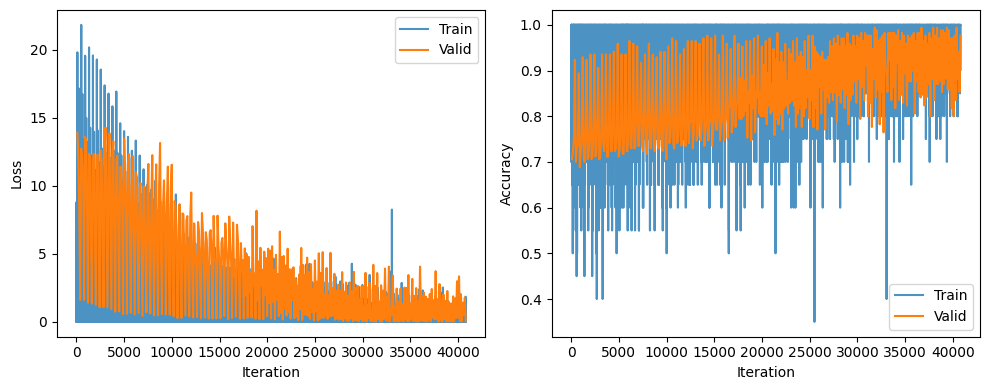

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(len(metrics['train_loss'])), metrics['train_loss'],
           alpha=0.8, label='Train')
ax[0].plot(metrics['val_idx'], metrics['val_loss'], label='Valid')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(len(metrics['train_acc'])), metrics['train_acc'],
           alpha=0.8, label='Train')
ax[1].plot(metrics['val_idx'], metrics['val_acc'], label='Valid')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [51]:
print('Your model...')
train_loss, train_accuracy = eval_model(model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')

"""print('\nBenchmark model')
train_loss, train_accuracy = eval_model(benchmark_model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(benchmark_model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')"""

Your model...
Train Loss 0.516 / Test Loss 0.516
Train Accuracy 94.755% / Test Accuracy 94.755%


"print('\nBenchmark model')\ntrain_loss, train_accuracy = eval_model(benchmark_model, train_loader, device=DEVICE)\ntest_loss, test_accuracy = eval_model(benchmark_model, test_loader, device=DEVICE)\nprint(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')\nprint(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')"

In [52]:
from sklearn.metrics import accuracy_score

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

data_x = train_loader.dataset.tensors[0].to(DEVICE)
data_y = train_loader.dataset.tensors[1].to(DEVICE)

test_x = test_loader.dataset.tensors[0].to(DEVICE)
text_y = test_loader.dataset.tensors[1].to(DEVICE)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
  model.train()
  y_logits = model(data_x)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, data_y.long())
  acc = accuracy_score(
      y_true = data_y.long().detach().cpu(),
      y_pred = y_pred.detach().cpu())
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(test_x).to(DEVICE)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1).to(DEVICE)

    test_loss = loss_fn(test_logits, test_y.long().to(DEVICE))
    test_acc = accuracy_score(y_true = test_y.long().detach().cpu(),
                    y_pred = test_preds.detach().cpu())

  if epoch % 2 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6003, Acc: 0.95% | Test loss: 92.9573, Test acc: 0.40%
Epoch: 2 | Loss: 0.5183, Acc: 0.95% | Test loss: 90.8722, Test acc: 0.41%


## MLP with `Delip Rao`

## 1. Create a function for vocabulary-based 

In [53]:
from collections import Counter
from argparse import Namespace
import json,os, re,string

import numpy as np, pandas as pd
import torch,torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

In [54]:
#Read data
df = pd.read_pickle('results/inflacion.pkl')[['text', 'label']]
df = df[df.label != 'neutro']
df['label'] = df['label'].replace({'negativo':0,'positivo':1})
df = df.rename(columns={'text':'review','label':'rating'})

# Filtering sentences with more than 5 words
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df = df[df['word_count'] > 5]
# Dropping the word_count column if not needed
df = df.drop(columns=['word_count'])
#df = df.drop_duplicates()

In [55]:
df.shape

(10207, 2)

In [56]:
from sklearn.model_selection import train_test_split
raw_train, raw_test = train_test_split(df, test_size = 0.05,
                                     random_state=42, shuffle=True,
                                     stratify=df.rating)
raw_train.to_pickle('data/raw_train.pkl')
raw_test.to_pickle('data/raw_test.pkl')

In [57]:
len(raw_train)

9696

In [58]:
args = Namespace(
  raw_train_dataset_csv = "data/raw_train.pkl",
  raw_test_dataset_csv = "data/raw_test.pkl",
  train_proportion = 0.7,
  val_proportion = 0.2,
  test_proportion=0.1,
  seed=1337,
  proportion_subset_of_train=0.9,
  output_munged_csv = "results/reviews_with_splits_lite.pkl"
  )

In [59]:
# Read raw data
train_reviews = pd.read_pickle(args.raw_train_dataset_csv)
len(train_reviews)

9696

In [60]:
from collections import defaultdict
# making the subset equal across the review classes
by_rating = defaultdict(list)
for _, row in train_reviews.iterrows():
    by_rating[row.rating].append(row.to_dict())
    
review_subset = []

for _, item_list in sorted(by_rating.items()):

    n_total = len(item_list)
    n_subset = int(args.proportion_subset_of_train * n_total)
    review_subset.extend(item_list[:n_subset])

review_subset = pd.DataFrame(review_subset)

In [62]:
# Splitting the subset by rating to create our new train, val, and test splits
by_rating = defaultdict(list)
for _, row in review_subset.iterrows():
    by_rating[row.rating].append(row.to_dict())
    
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'



In [63]:
# Create split data
#final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list)

In [66]:
# Create split data
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    # Add to final list
    final_list.extend(item_list)

In [67]:
# Write split data to file
final_reviews = pd.DataFrame(final_list)

In [68]:
# Write split data to file
final_reviews = pd.DataFrame(final_list)
final_reviews.split.value_counts()

split
train    6107
val      1745
test      873
Name: count, dtype: int64

In [69]:
# Preprocess the reviews
def preprocess_text(text):
    text = text.lower()
    #text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
final_reviews.review = final_reviews.review.apply(preprocess_text)

In [70]:
final_reviews['rating'] = final_reviews.rating.apply({0: 'negative', 1: 'positive'}.get)

In [184]:
final_reviews.head()

,review,rating,split
0,datos desglosados ano exhiben realidad valor s...,negative,train
1,reforma fiscal siguiente ano refuerce finanzas...,negative,train
2,menor avance indicadores da contexto pandemia ...,negative,train
3,empresario mexicano destacado interes construc...,negative,train
4,mexico hacer hacer manera mas sencilla poder i...,negative,train


In [71]:
final_reviews.to_pickle(args.output_munged_csv)

## The vocabulary

In [72]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

## The vectorizer

In [73]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=600):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}


## The Dataset

In [74]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = self.train_df.shape[0]

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = self.val_df.shape[0]

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = self.test_df.shape[0]

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_pickle(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_pickle(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="mps"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [75]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

In [76]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [77]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [78]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='results/reviews_with_splits_lite.pkl',
    # review_csv='data/yelp/reviews_with_splits_full.csv',
    save_dir='data/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=50,
    early_stopping_criteria=5,
    learning_rate=0.005,
    num_epochs=120,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    mps=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.mps = True

print("Using MPS: {}".format(args.mps))

args.device = torch.device("mps" if args.mps else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.mps)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	data/vectorizer.json
	data/model.pth
Using MPS: True


## Initialization

In [79]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer


In [80]:
classifier

ReviewClassifier(
  (fc1): Linear(in_features=103, out_features=1, bias=True)
)

## Training loop

In [81]:
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/120 [00:00<?, ?it/s]

split=train:   0%|          | 0/122 [00:00<?, ?it/s]

split=val:   0%|          | 0/34 [00:00<?, ?it/s]

In [82]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [83]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.685
Test Accuracy: 55.18


In [84]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.8):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = F.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [85]:
test_review = "los indicadores de desempleo no son nada alentadores para la economia"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

los indicadores de desempleo no son nada alentadores para la economia -> negative


In [86]:
classifier.fc1.weight.shape

torch.Size([1, 103])

In [87]:
# Sort weights
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

# Top 20 words
print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

# Top 20 negative words
print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Positive Reviews:
--------------------------------------
pesos
marzo
abril
pasado
laboral
primer
alza
gobierno
unidos
trimestre
menor
ano
mexico
datos
monetaria
anual
deuda
reserva
mes
ingresos
====



Influential words in Negative Reviews:
--------------------------------------
petroleo
desempleo
covid
productos
precios
economica
produccion
incremento
pandemia
ciento.
periodo
estan
mientras
empresas
ciento
economia
dos
politica
mismo
federal


## MLP with Delip Rao

In [88]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [89]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps characters to integers
            rating_vocab (Vocabulary): maps nationalities to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """
        Args:
            review (str): the review

        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding 
        """
        vocab = self.review_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in review:
            one_hot[vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the reviews dataset
        Returns:
            an instance of the reviewVectorizer
        """
        review_vocab = Vocabulary(unk_token="@")
        rating_vocab = Vocabulary(add_unk=False)

        for index, row in review_df.iterrows():
            for letter in row.review:
                review_vocab.add_token(letter)
            rating_vocab.add_token(row.rating)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])
        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}


In [90]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instatiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = review_df.rating.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.rating_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_pickle(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_pickle(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_review)
                label (y_rating)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_review': review_vector,
                'y_rating': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="mps"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## MLP model

In [205]:
class ReviewClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying reviewes """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu_1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu_2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        #intermediate_vector = self.relu_2(self.fc2(self.relu_1(self.fc1(x_in))))
        prediction_vector = F.dropout(self.fc3(
            self.relu_2(
                F.dropout(self.fc2(
                    F.dropout(
                        self.relu_1(
                            self.fc1(x_in)), 
                            p=0.5)), 
                            p=0.5))), 
                            p=0.5)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training


In [206]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [207]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [208]:
args = Namespace(
    # Data and path information
    review_csv='results/reviews_with_splits_lite.pkl',
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="results",
    # Model hyper parameters
    hidden_dim=256,
    # Training  hyper parameters
    seed=1337,
    num_epochs=120,
    early_stopping_criteria=5,
    learning_rate=0.00001,
    batch_size=28,
    # Runtime options
    cuda=False,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = True

args.device = torch.device("mps" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	results/vectorizer.json
	results/model.pth
Using CUDA: True


In [209]:
if args.reload_from_files:
    # training from a checkpoint
    print("Reloading!")
    ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    print("Creating fresh!")
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
classifier = ReviewClassifier(input_dim=len(vectorizer.review_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.rating_vocab))

Creating fresh!


## Training loop

In [210]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_review'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_rating'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_rating'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_review'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_rating'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_rating'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_4642/1479966538.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar = tqdm_notebook(desc='training routine',


training routine:   0%|          | 0/120 [00:00<?, ?it/s]

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_4642/1479966538.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  train_bar = tqdm_notebook(desc='split=train',


split=train:   0%|          | 0/218 [00:00<?, ?it/s]

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_4642/1479966538.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  val_bar = tqdm_notebook(desc='split=val',


split=val:   0%|          | 0/62 [00:00<?, ?it/s]

In [211]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_review'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_rating'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_rating'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.6935271466931988;
Test Accuracy: 53.57142857142858


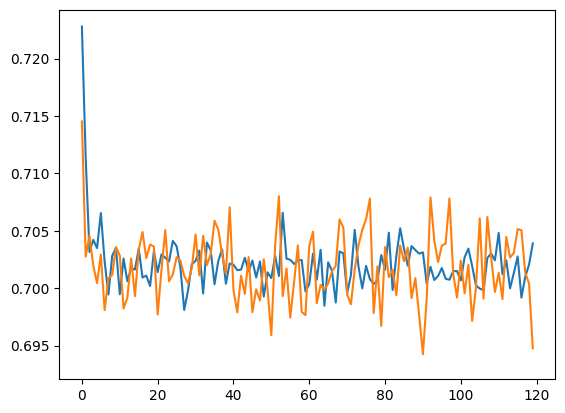

In [212]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_loss'])
plt.plot(train_state['val_loss'])
plt.plot(train_state['test_loss']);

## Inference

In [213]:
def predict_rating(review, classifier, vectorizer):
    """Predict the rating from a new review
    
    Args:
        review (str): the review to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely rating and its probability
    """
    vectorized_review = vectorizer.vectorize(review)
    vectorized_review = torch.tensor(vectorized_review).view(1, -1)
    result = classifier(vectorized_review, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_rating = vectorizer.rating_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'rating': predicted_rating, 'probability': probability_value}

In [214]:
new_review = 'el aumento de precios tiene un impacto negativo en el crecimiento'
classifier = classifier.cpu()
prediction = predict_rating(new_review, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_review,
                                    prediction['rating'],
                                    prediction['probability']))

el aumento de precios tiene un impacto negativo en el crecimiento -> negative (p=0.50)


In [217]:
def predict_topk_rating(name, classifier, vectorizer, k=5):
    vectorized_name = vectorizer.vectorize(name)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        rating = vectorizer.rating_vocab.lookup_index(index)
        results.append({'rating': rating, 
                        'probability': prob_value})
    
    return results


new_review = input("Enter a review to classify: ")
classifier = classifier.cpu()

k = int(input("How many of the top predictions to see? "))
if k > len(vectorizer.rating_vocab):
    print("Sorry! That's more than the # of ratings we have.. defaulting you to max size :)")
    k = len(vectorizer.rating_vocab)
    
predictions = predict_topk_rating(new_review, classifier, vectorizer, k=k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print("{} -> {} (p={:0.2f})".format(new_review,
                                        prediction['rating'],
                                        prediction['probability']))

Top 2 predictions:
economia -> negative (p=0.53)
economia -> positive (p=0.47)


## CNN

In [218]:
import os
if not os.path.exists('data/surnames'):
  os.makedirs('data/surnames')

args = Namespace(
    raw_dataset_csv="data/surnames/surnames.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/surnames/surnames_with_splits.csv",
    seed=1337
)

In [219]:
#Read data
surnames = df
surnames = surnames.rename(columns={'review':'surname', 'rating':'nationality'})
surnames.to_csv('data/surnames/surnames.csv', index=False)

In [220]:
from collections import defaultdict
# Splitting train by nationality
# Create dict
by_nationality = defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [221]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [222]:
# Read raw data
surnames = pd.read_csv(args.raw_dataset_csv, header=0, index_col=False)

In [223]:
surnames.head()

,surname,nationality
0,apunto vez quitada operaciones remanente recur...,0
1,el sistema simplemente crecimiento piramide po...,0
2,el sistema simplemente crecimiento piramide po...,0
3,apunto vez quitada operaciones remanente recur...,0
4,administra millones pesos ahorro familias entr...,0


In [224]:
# Splitting train by nationality
# Create dict
by_nationality = defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [225]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [226]:
# Write split data to file
final_surnames = pd.DataFrame(final_list)
# Write munged data to CSV
final_surnames.to_csv(args.output_munged_csv, index=False)

## Vectorize data

In [227]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [228]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab, max_surname_length):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
            max_surname_length (int): the length of the longest surname
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
        self._max_surname_length = max_surname_length

    def vectorize(self, surname):
        """
        Args:
            surname (str): the surname
        Returns:
            one_hot_matrix (np.ndarray): a matrix of one-hot vectors
        """

        one_hot_matrix_size = (len(self.surname_vocab), self._max_surname_length)
        one_hot_matrix = np.zeros(one_hot_matrix_size, dtype=np.float32)
                               
        for position_index, character in enumerate(surname):
            character_index = self.surname_vocab.lookup_token(character)
            one_hot_matrix[character_index][position_index] = 1
        
        return one_hot_matrix

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        max_surname_length = 0

        for index, row in surname_df.iterrows():
            max_surname_length = max(max_surname_length, len(row.surname))
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab, max_surname_length)

    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab, 
                   max_surname_length=contents['max_surname_length'])

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable(), 
                'max_surname_length': self._max_surname_length}


In [229]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            name_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer
        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameDataset
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        surname_matrix = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_surname': surname_matrix,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## Classifier

In [230]:
class SurnameClassifier(nn.Module):
    def __init__(self, initial_num_channels, num_classes, num_channels):
        """
        Args:
            initial_num_channels (int): size of the incoming feature vector
            num_classes (int): size of the output prediction vector
            num_channels (int): constant channel size to use throughout network
        """
        super(SurnameClassifier, self).__init__()
        
        self.convnet = nn.Sequential(
            nn.Conv1d(in_channels=initial_num_channels, 
                      out_channels=num_channels, kernel_size=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=2),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=3, stride=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=4, stride=3),
            nn.ELU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, 
                      kernel_size=2),
            nn.ELU()
        )
        self.fc = nn.Linear(num_channels, num_classes)

    def forward(self, x_surname, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_surname (torch.Tensor): an input data tensor. 
                x_surname.shape should be (batch, initial_num_channels, max_surname_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        features = self.convnet(x_surname)#.squeeze(dim=2)
        # Flatten the features from the convnet
        features = features.view(features.size(0), -1)  # Reshape to [batch_size, num_channels * output_size]
       
        prediction_vector = self.fc(features)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training

In [231]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

In [232]:
def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

In [233]:
def compute_accuracy(y_pred, y_target):
    y_pred_indices = y_pred.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [234]:
args = Namespace(
    # Data and Path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="data/surnames",
    # Model hyper parameters
    hidden_dim=30,
    num_channels=64,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.00001,
    batch_size=64,
    num_epochs=30,
    early_stopping_criteria=5,
    dropout_p=0.1,
    # Runtime options
    cuda=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
    catch_keyboard_interrupt=True
)


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = True

args.device = torch.device("mps" if args.cuda else "cpu")
print("Using MPS: {}".format(args.cuda))

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	data/surnames/vectorizer.json
	data/surnames/model.pth
Using MPS: True


In [235]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(initial_num_channels=len(vectorizer.surname_vocab), 
                               num_classes=len(vectorizer.nationality_vocab),
                               num_channels=args.num_channels)

classifer = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(weight=dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

In [236]:
classifier

SurnameClassifier(
  (convnet): Sequential(
    (0): Conv1d(29, 64, kernel_size=(3,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (7): ELU(alpha=1.0)
    (8): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (9): ELU(alpha=1.0)
    (10): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (11): ELU(alpha=1.0)
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(2,))
    (13): ELU(alpha=1.0)
    (14): Conv1d(64, 64, kernel_size=(3,), stride=(3,))
    (15): ELU(alpha=1.0)
    (16): Conv1d(64, 64, kernel_size=(4,), stride=(3,))
    (17): ELU(alpha=1.0)
    (18): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
    (19): ELU(alpha=1.0)
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [237]:
epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/30 [00:00<?, ?it/s]

split=train:   0%|          | 0/111 [00:00<?, ?it/s]

split=val:   0%|          | 0/23 [00:00<?, ?it/s]

In [238]:
classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_surname'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_nationality'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 0.693135917186737;
Test Accuracy: 50.74728260869565


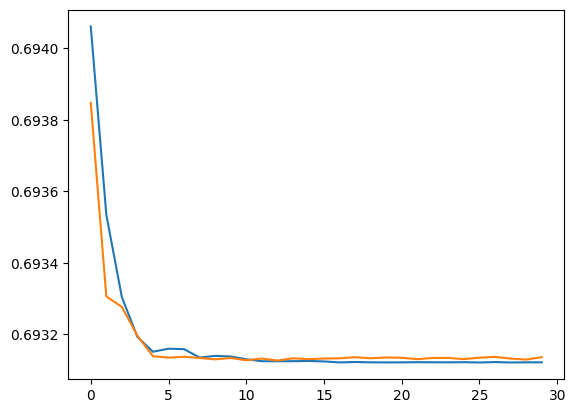

In [239]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_loss'])
plt.plot(train_state['val_loss'])
plt.plot(train_state['test_loss']);

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    """Predict the nationality from a new surname
    
    Args:
        surname (str): the surname to classifier
        classifier (SurnameClassifer): an instance of the classifier
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    Returns:
        a dictionary with the most likely nationality and its probability
    """
    vectorized_surname = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(0)
    result = classifier(vectorized_surname, apply_softmax=True)

    probability_values, indices = result.max(dim=1)
    index = indices.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)
    probability_value = probability_values.item()

    return {'nationality': predicted_nationality, 'probability': probability_value}
new_surname = input("Enter a surname to classify: ")
classifier = classifier.cpu()
prediction = predict_nationality(new_surname, classifier, vectorizer)
print("{} -> {} (p={:0.2f})".format(new_surname,
                                    prediction['nationality'],
                                    prediction['probability']))

economia -> 0 (p=0.50)
